In [1]:
import torch
from torch.autograd import Variable
from tqdm import tqdm, trange

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

from pathlib import Path

seed = 42 #424
np.random.seed(seed)
torch.manual_seed(seed)
#NOTE! This only works for non cudnn. gpu needs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import scipy.stats as stats

In [2]:
%load_ext autoreload

%autoreload 2


In [3]:
plt.rcParams["figure.figsize"] = (20,10)
sns.set_context("poster")
sns.set_style("ticks")
#sns.set_style("dark")
sns.despine()


<Figure size 1440x720 with 0 Axes>

In [4]:
iters = 100
l2 = 1
n_std = 4
epochs = 300#500 is great#500#10000#1000
all_predictions = True
toy = False

showcase = False

if toy:
    epochs = 2000
    all_predictions = True




In [5]:
from helpers import showcase_code

# Kaggle housing data regression with uncertainty estimates

This is a follow up to the notebook about the toy problem, showing how the presented techiques can be used for real world datasets as well.

## The Data

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

The dataset has been stripped of non-numerical variables for ease of use, extreme outliers are removed and mean / std normalisation has been done.

This leaves us with 37 predictors and one target variable.

The dataset has been split in train (0.8) and test set (0.2). As we can see, sorting the dataset by ascending target variable is very beneficial for visualisation purposes, the dataset presented to the models are shuffled randomly.


In [6]:
from data_loaders import get_X_y, generate_y
showcase_code('data_loaders.py')

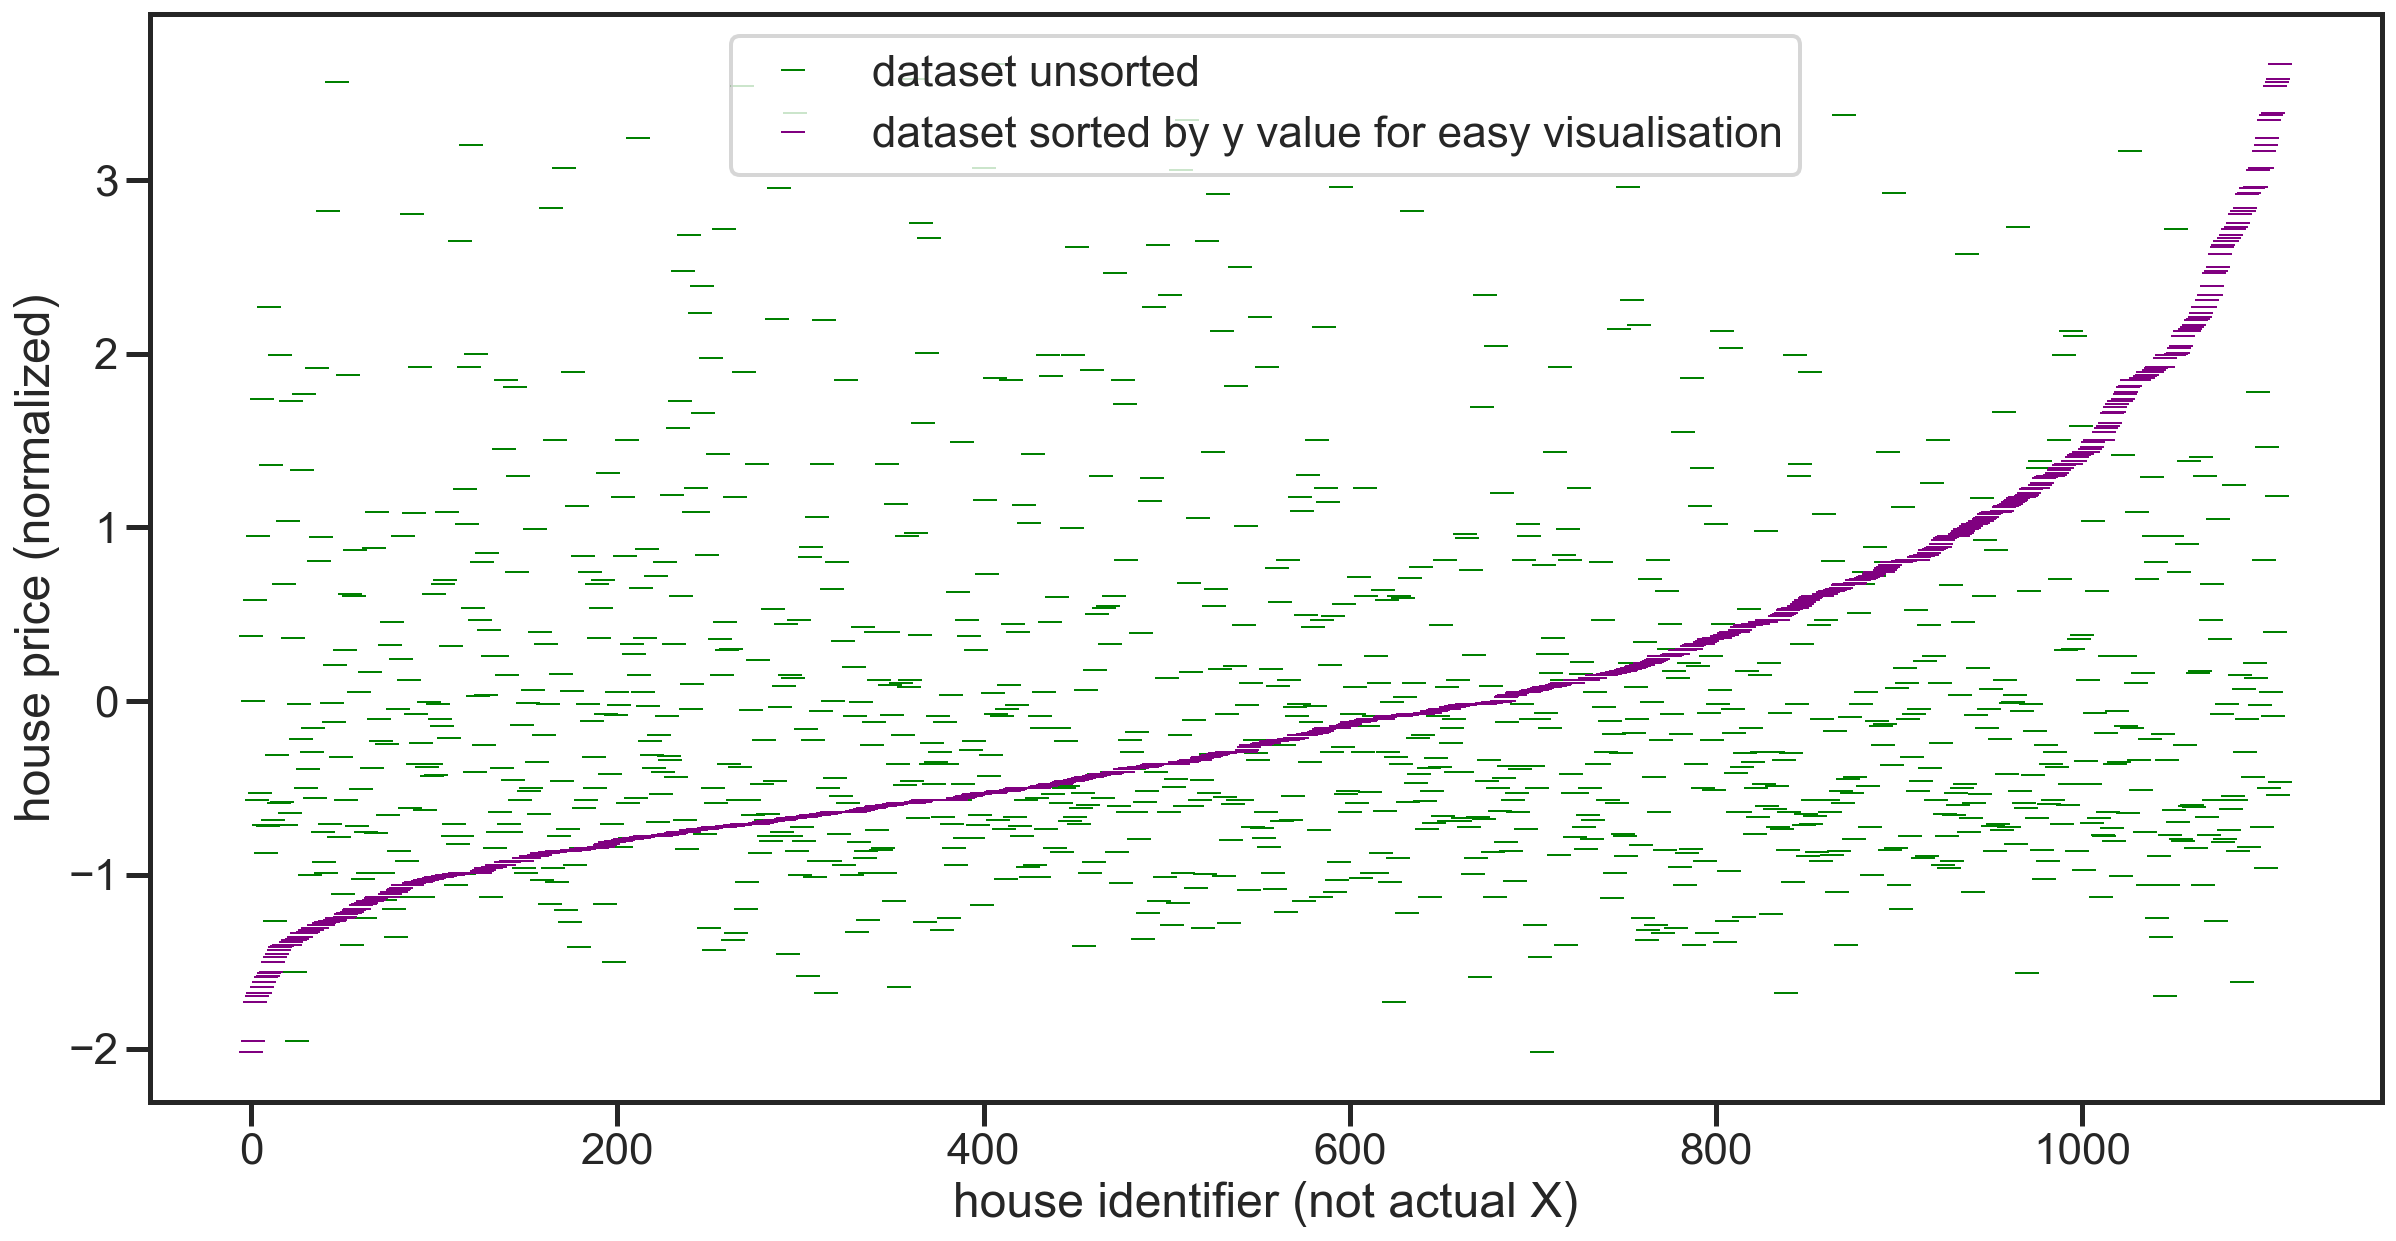

In [7]:
X_train, X_test, y_train, y_test, N, output_dims  = get_X_y(toy,seed=seed)

$$p(y_{*}|D) = p(y_{*}|f_{*})p(f_{*}|\mu_{*}\\sigma^{2}_{*})$$


In [10]:

showcase_code('measures.py')

In [11]:
from helpers import plot_uncertainty, plot_generating_function
showcase_code('helpers.py')


In [12]:
if toy:
    plot_generating_function(X_test,y_test,generate_y,0.3,N)

In [13]:
from nn_models.base_model import SimpleModel
showcase_code('nn_models/base_model.py')


In [14]:

from nn_models.base_ensemble import VanillaEnsemble
showcase_code('nn_models/base_ensemble.py')
    

In [15]:
vanilla = VanillaEnsemble(toy,output_dims)

cobeau: (-0.04614603128678273, 0.4939477399905708)
nlpd: 0.8237502548436894.
 nlpds of just mean and just std of the model:
0.4136553852883003


C:\Users\thoma\Documents\GitHub\uncertainty_regression_pytorch\models\measures.py:11: RuntimeWarning: invalid value encountered in log
  nlpd = 1/2 * (y-y_pred)**2 / y_std + np.log(y_std)


nan
error: 0.6919441369104922


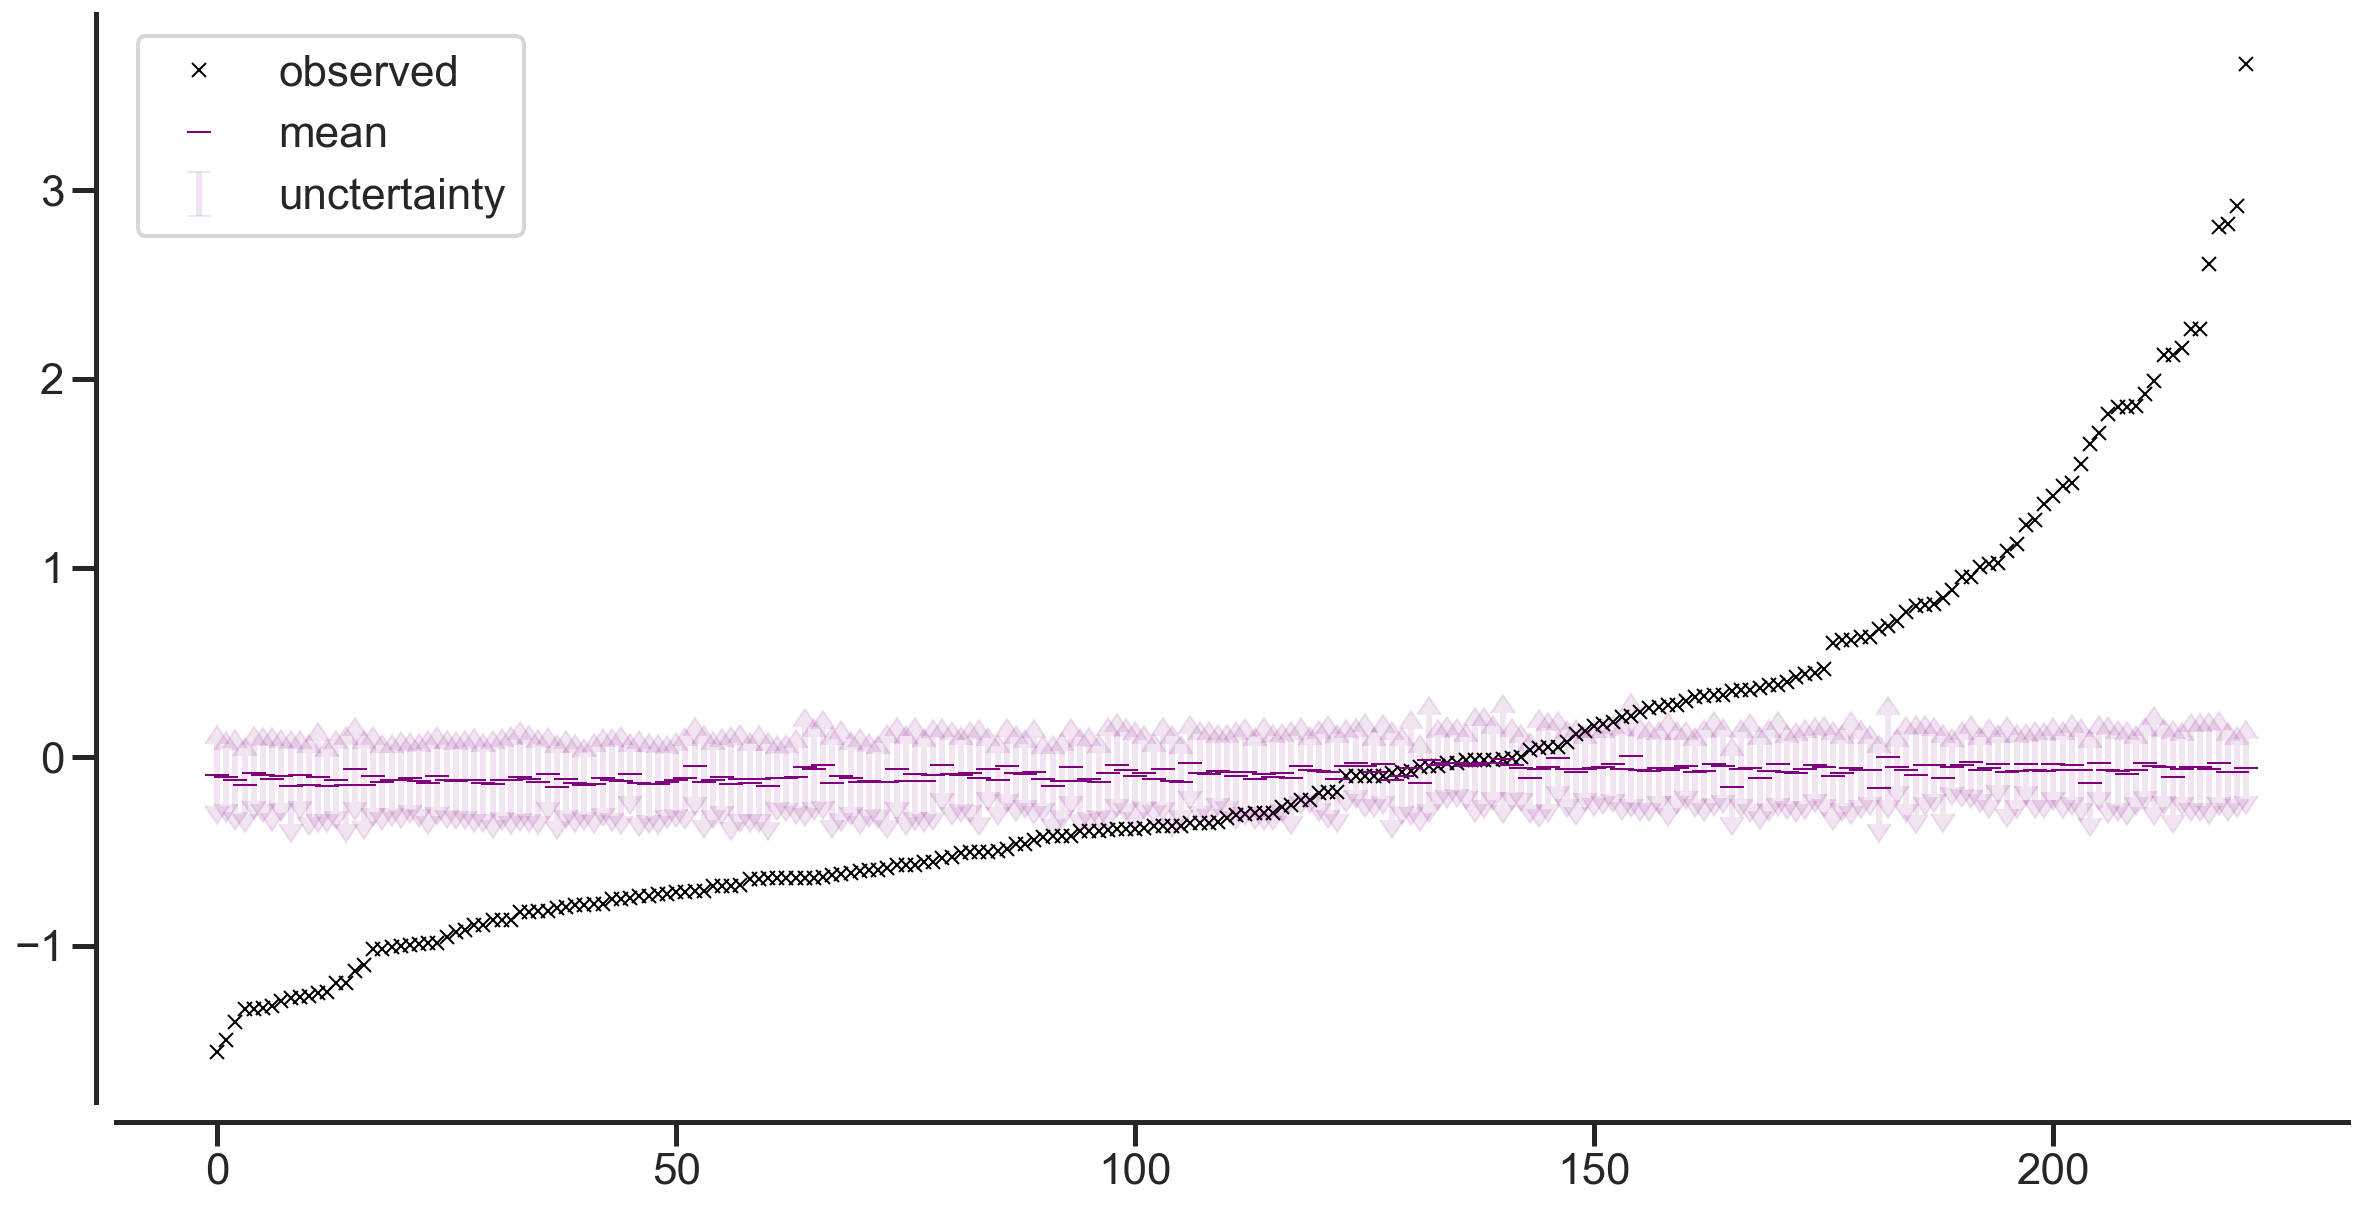

In [16]:
plot_uncertainty(vanilla,X_test,y_test,toy,all_predictions=all_predictions)

100%|████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.51it/s]


final loss: [tensor(0.0198, grad_fn=<MseLossBackward>), tensor(0.0168, grad_fn=<MseLossBackward>), tensor(0.0161, grad_fn=<MseLossBackward>), tensor(0.0173, grad_fn=<MseLossBackward>), tensor(0.0156, grad_fn=<MseLossBackward>), tensor(0.0169, grad_fn=<MseLossBackward>), tensor(0.0149, grad_fn=<MseLossBackward>), tensor(0.0159, grad_fn=<MseLossBackward>), tensor(0.0178, grad_fn=<MseLossBackward>), tensor(0.0156, grad_fn=<MseLossBackward>)]
Wall time: 54.5 s


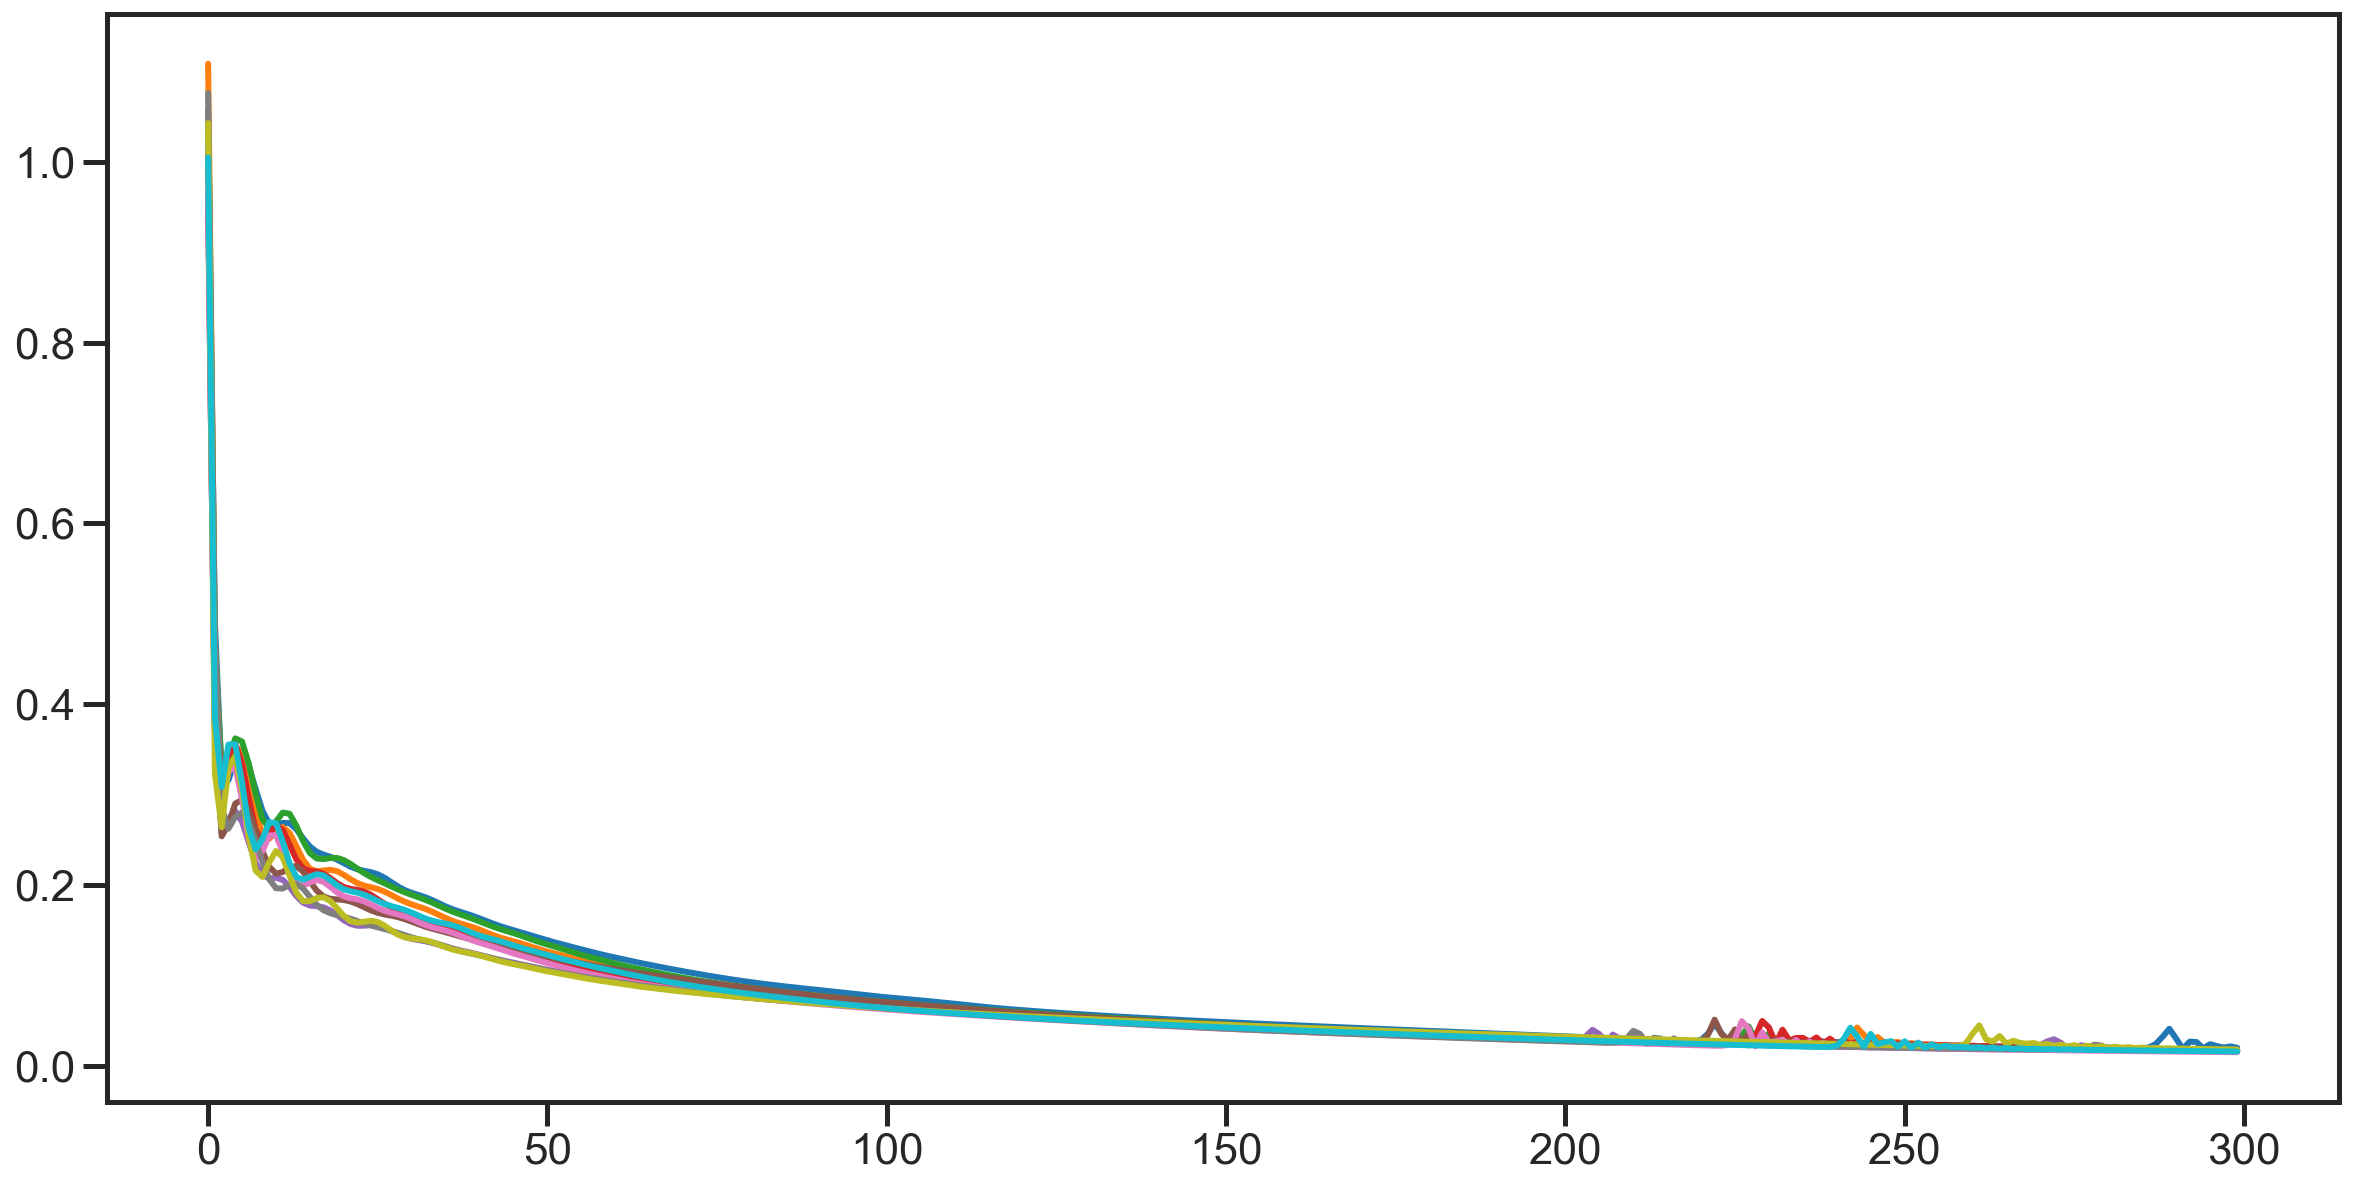

In [17]:
%%time

losses = []

for i in trange(epochs):
    losses.append(vanilla.fit_model(X_train,y_train))
    
    
plt.plot(losses)
print(f'final loss: {losses[-1]}')

cobeau: (0.26909406240810685, 3.5245371390653614e-16)
nlpd: -3.109423926870607.
 nlpds of just mean and just std of the model:
0.5190551025860449
nan
error: 0.0827543257714766


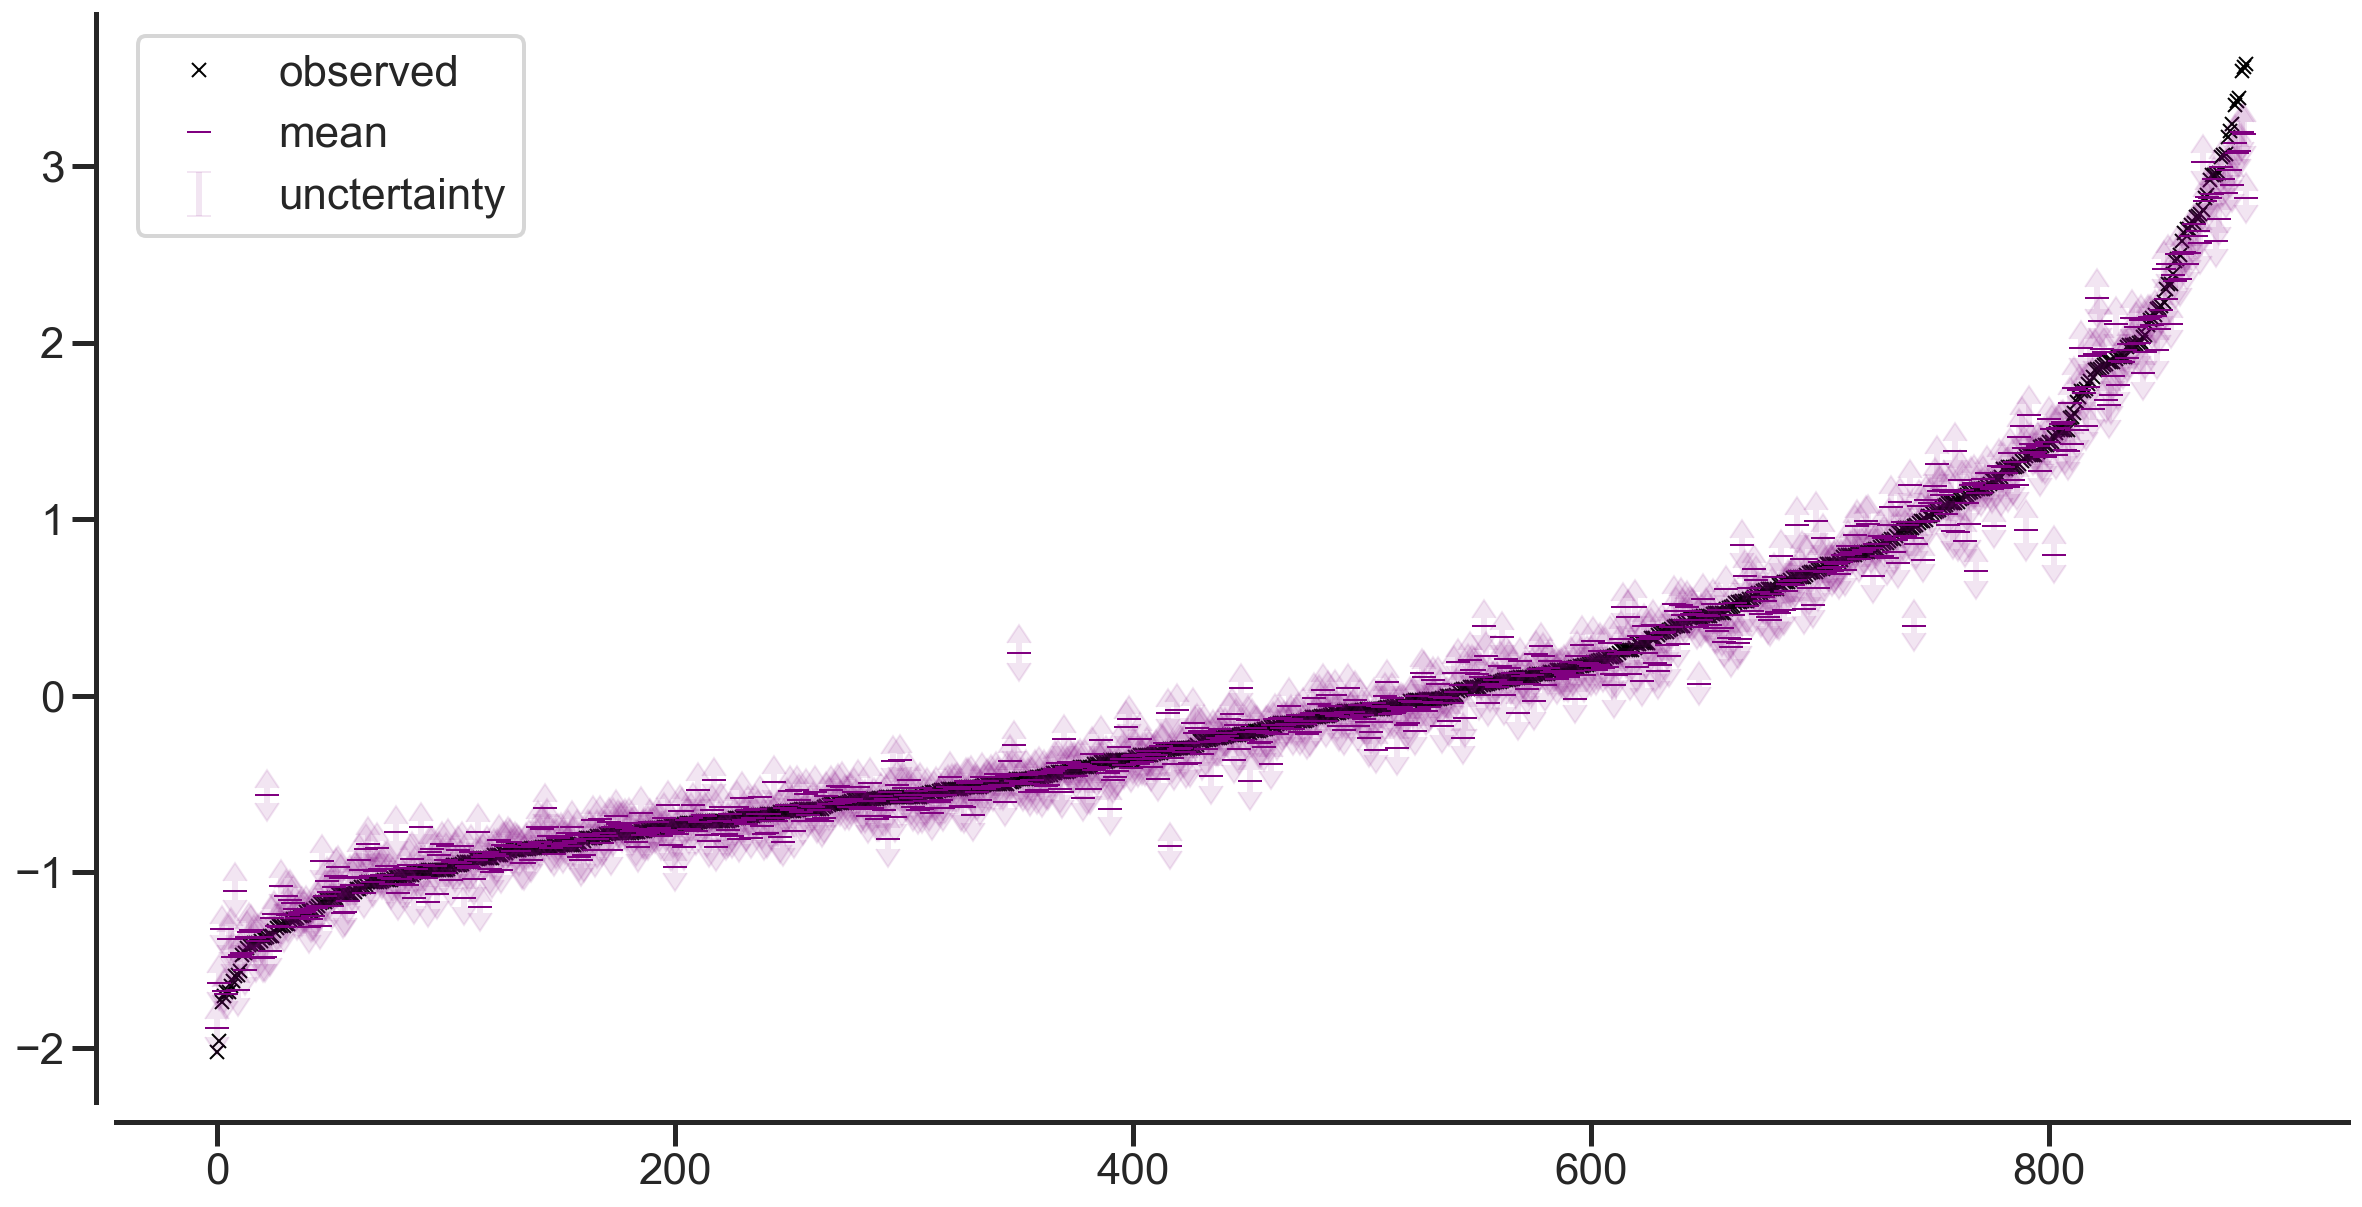

In [18]:
plot_uncertainty(vanilla,X_train,y_train,toy,all_predictions=True)

cobeau: (0.35582559261036395, 5.0028036582560245e-08)
nlpd: -2.000144423013.
 nlpds of just mean and just std of the model:
0.4136553852883003
nan
error: 0.22521602389454295


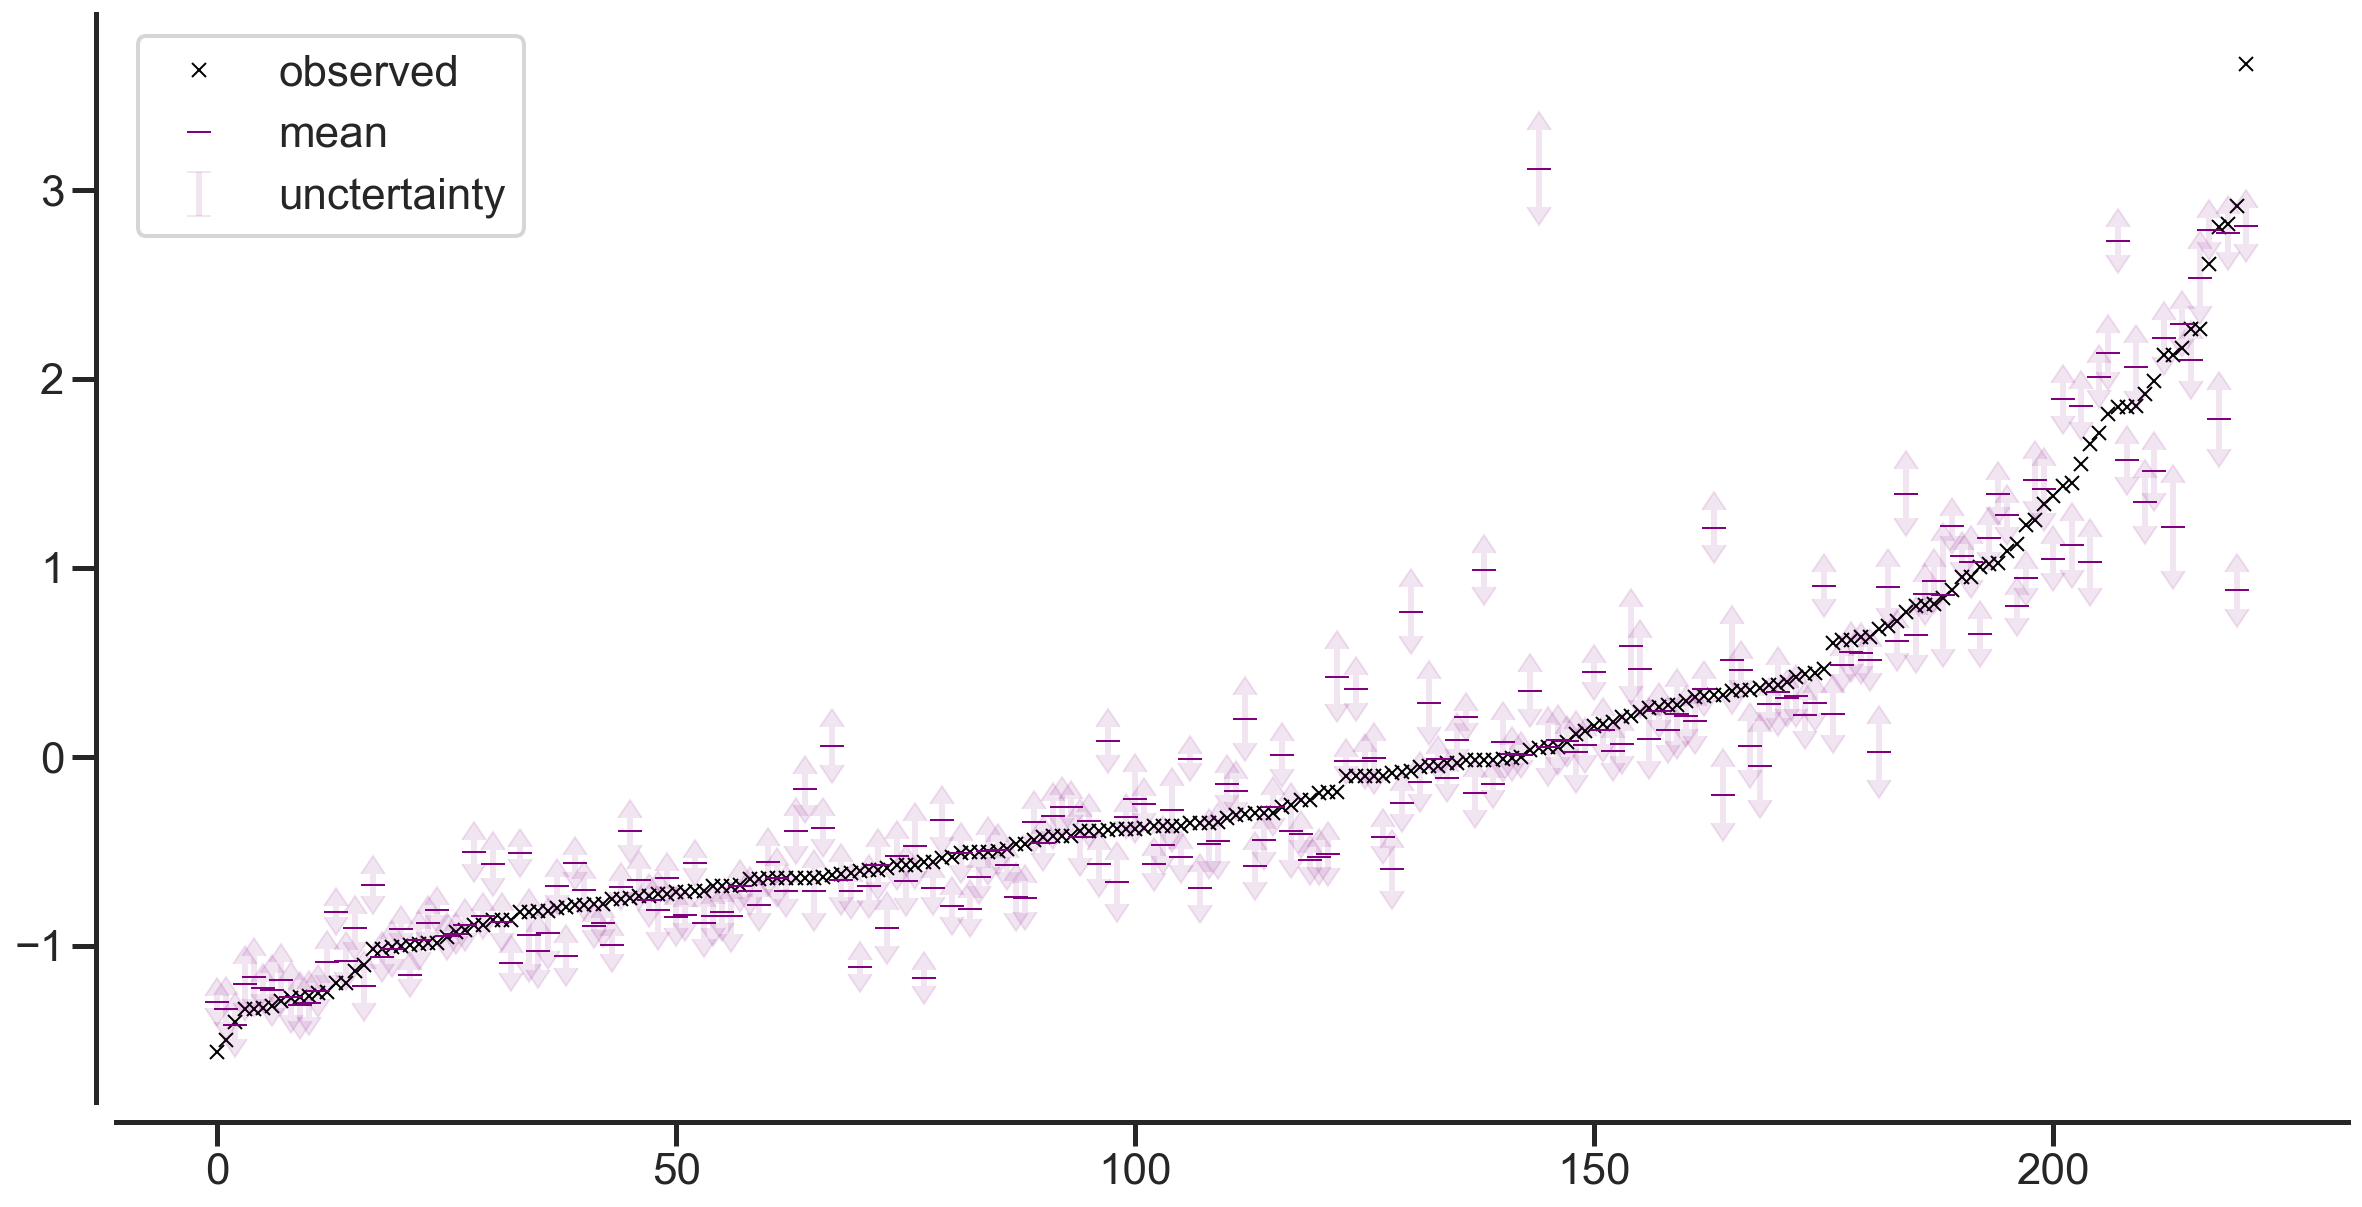

In [19]:
plot_uncertainty(vanilla,X_test,y_test,toy,all_predictions=False)

In [20]:
from nn_models.ensembles import ShuffleEnsemble

showcase_code('nn_models/ensembles.py','ShuffleEnsemble')

In [21]:
shuffle = ShuffleEnsemble(toy,output_dims)

100%|████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:04<00:00,  4.68it/s]


final loss: [tensor(0.0201, grad_fn=<MseLossBackward>), tensor(0.0183, grad_fn=<MseLossBackward>), tensor(0.0205, grad_fn=<MseLossBackward>), tensor(0.0259, grad_fn=<MseLossBackward>), tensor(0.0186, grad_fn=<MseLossBackward>), tensor(0.0164, grad_fn=<MseLossBackward>), tensor(0.0180, grad_fn=<MseLossBackward>), tensor(0.0203, grad_fn=<MseLossBackward>), tensor(0.0276, grad_fn=<MseLossBackward>), tensor(0.0158, grad_fn=<MseLossBackward>)]
Wall time: 1min 4s


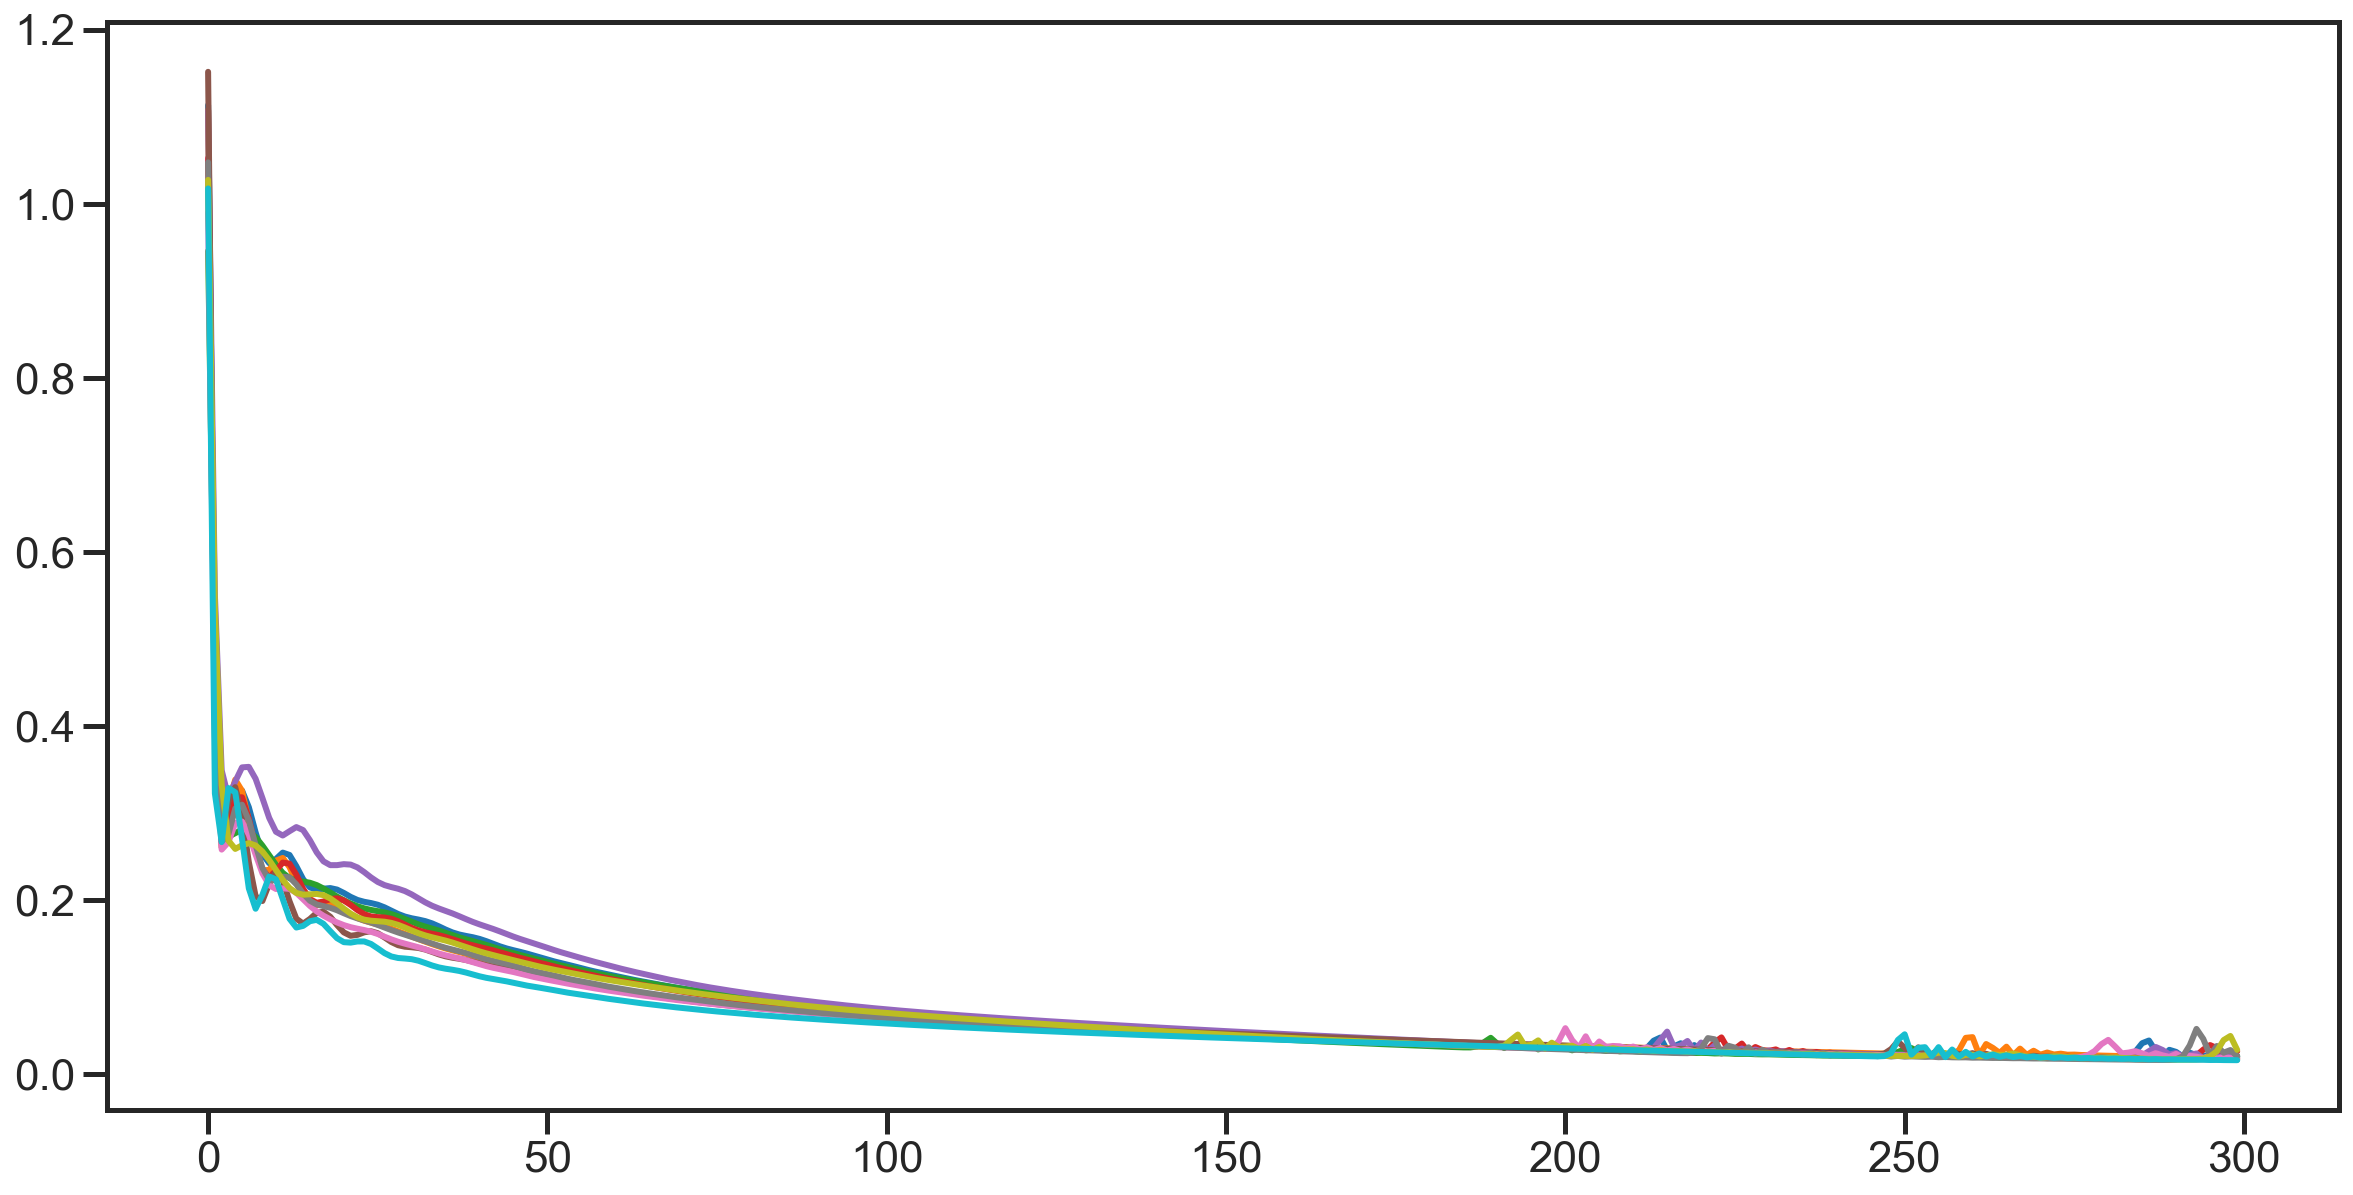

In [22]:
%%time

losses = []

for i in trange(epochs):
    losses.append( shuffle.fit_model(X_train,y_train))
    
    
plt.plot(losses)
print(f'final loss: {losses[-1]}')

cobeau: (0.38711559228252507, 2.3766151049379834e-09)
nlpd: -1.8782422127499077.
 nlpds of just mean and just std of the model:
0.4136553852883003
nan
error: 0.22504900017559473


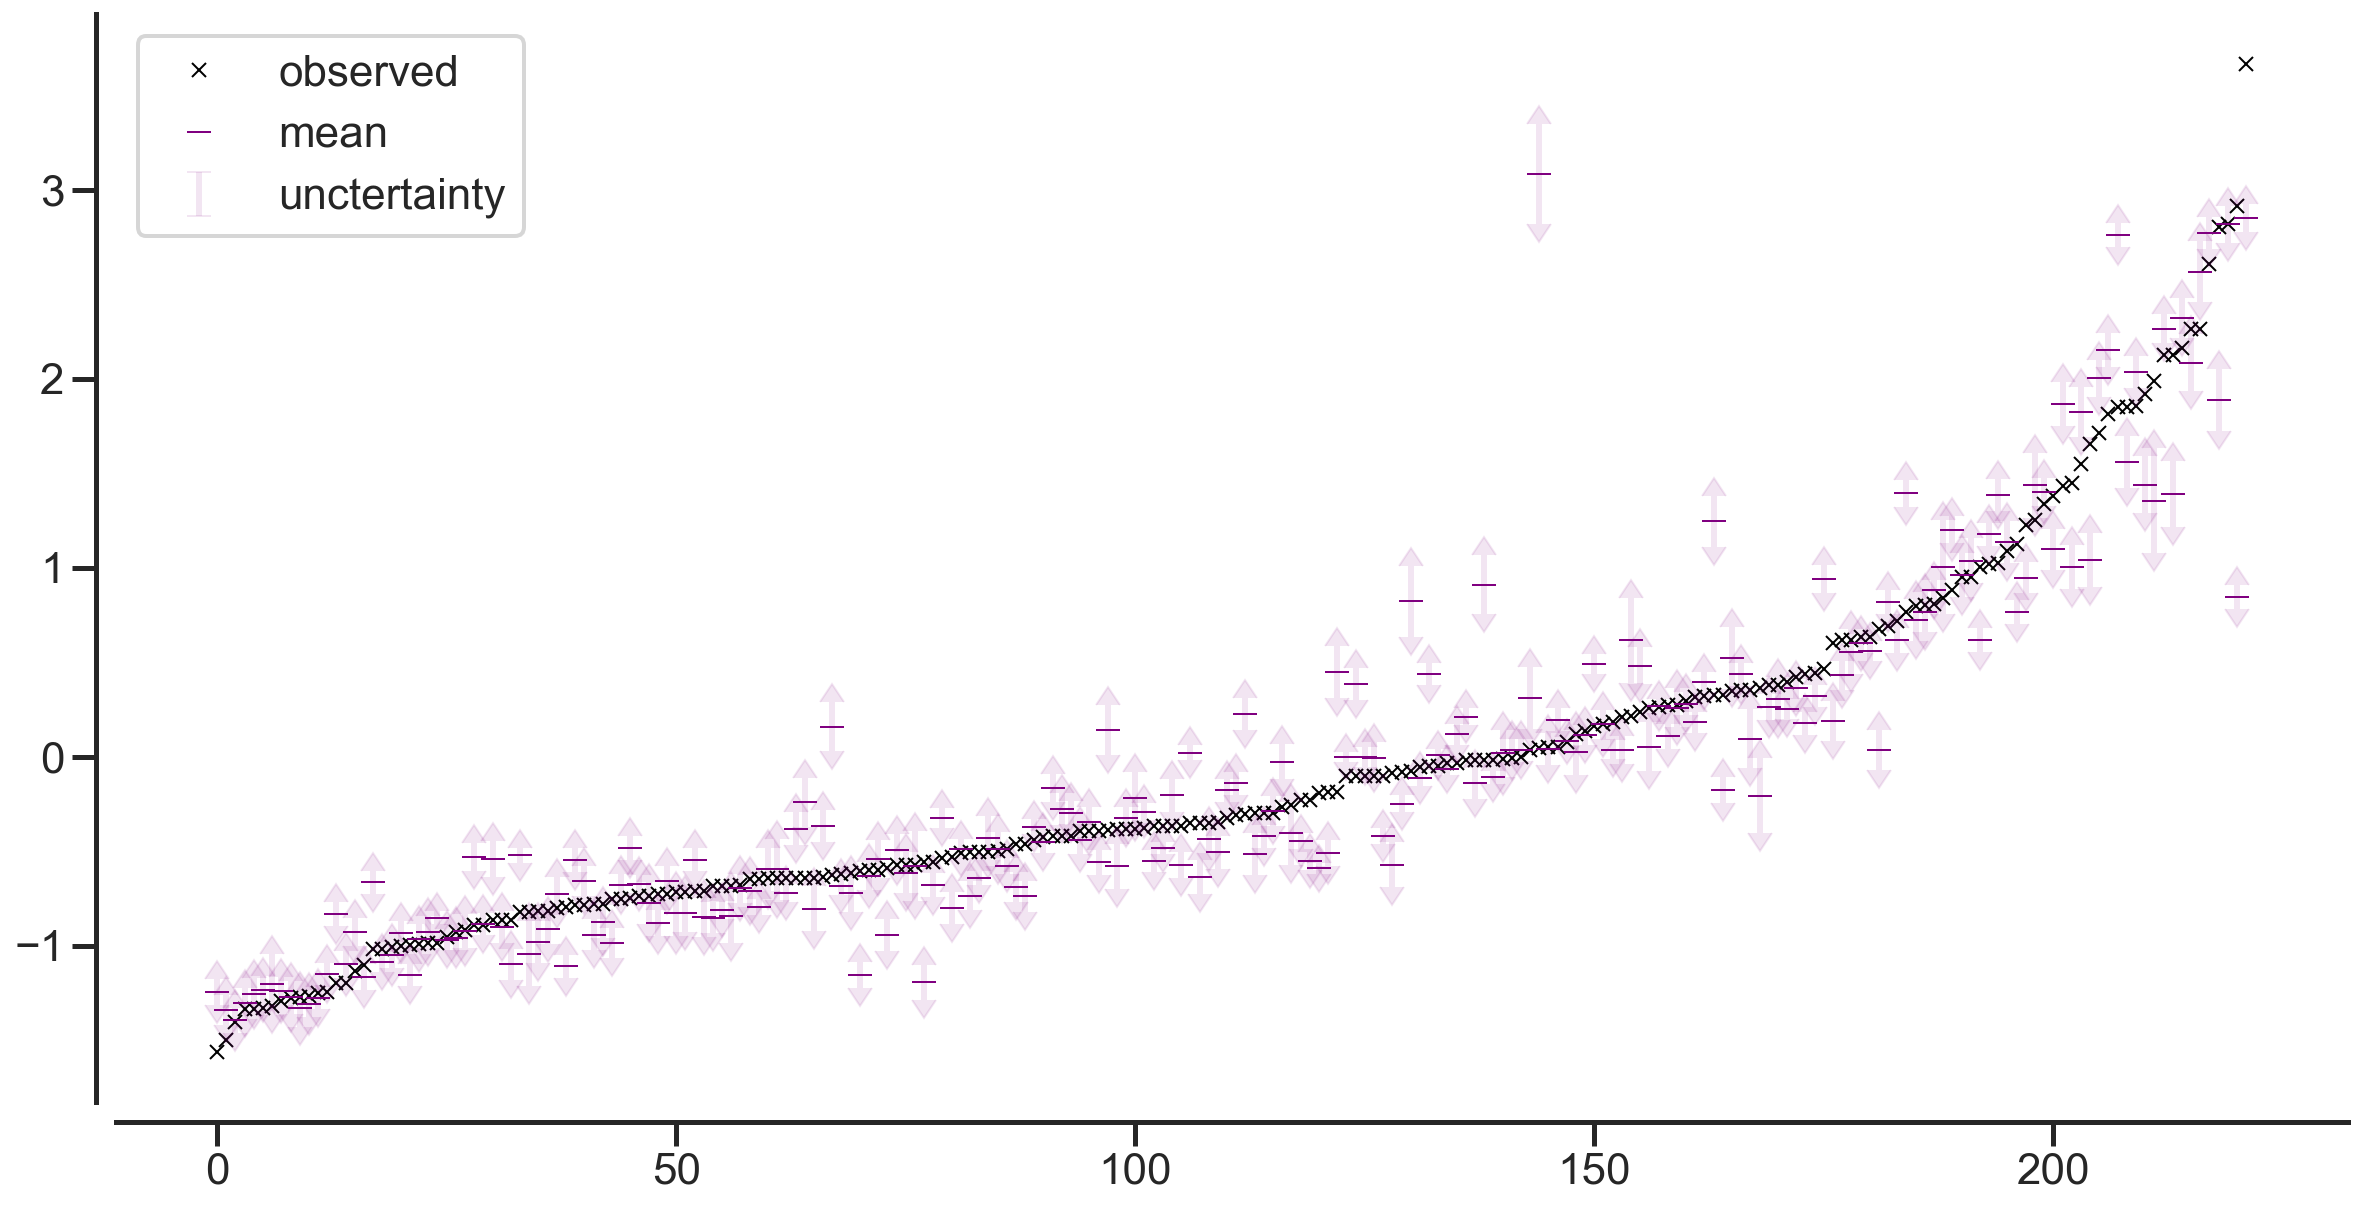

In [23]:
plot_uncertainty(shuffle,X_test,y_test,toy,all_predictions=all_predictions)

In [24]:
from nn_models.ensembles import BootstrapEnsemble

showcase_code('nn_models/ensembles.py','BootstrapEnsemble')

In [25]:
bootstrap = BootstrapEnsemble(toy,output_dims,dataset_lenght = len(X_train))

100%|████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:49<00:00,  6.12it/s]


final loss: [tensor(0.0253, grad_fn=<MseLossBackward>), tensor(0.0113, grad_fn=<MseLossBackward>), tensor(0.0121, grad_fn=<MseLossBackward>), tensor(0.0097, grad_fn=<MseLossBackward>), tensor(0.0098, grad_fn=<MseLossBackward>), tensor(0.0197, grad_fn=<MseLossBackward>), tensor(0.0095, grad_fn=<MseLossBackward>), tensor(0.0106, grad_fn=<MseLossBackward>), tensor(0.0112, grad_fn=<MseLossBackward>), tensor(0.0134, grad_fn=<MseLossBackward>)]
Wall time: 49.1 s


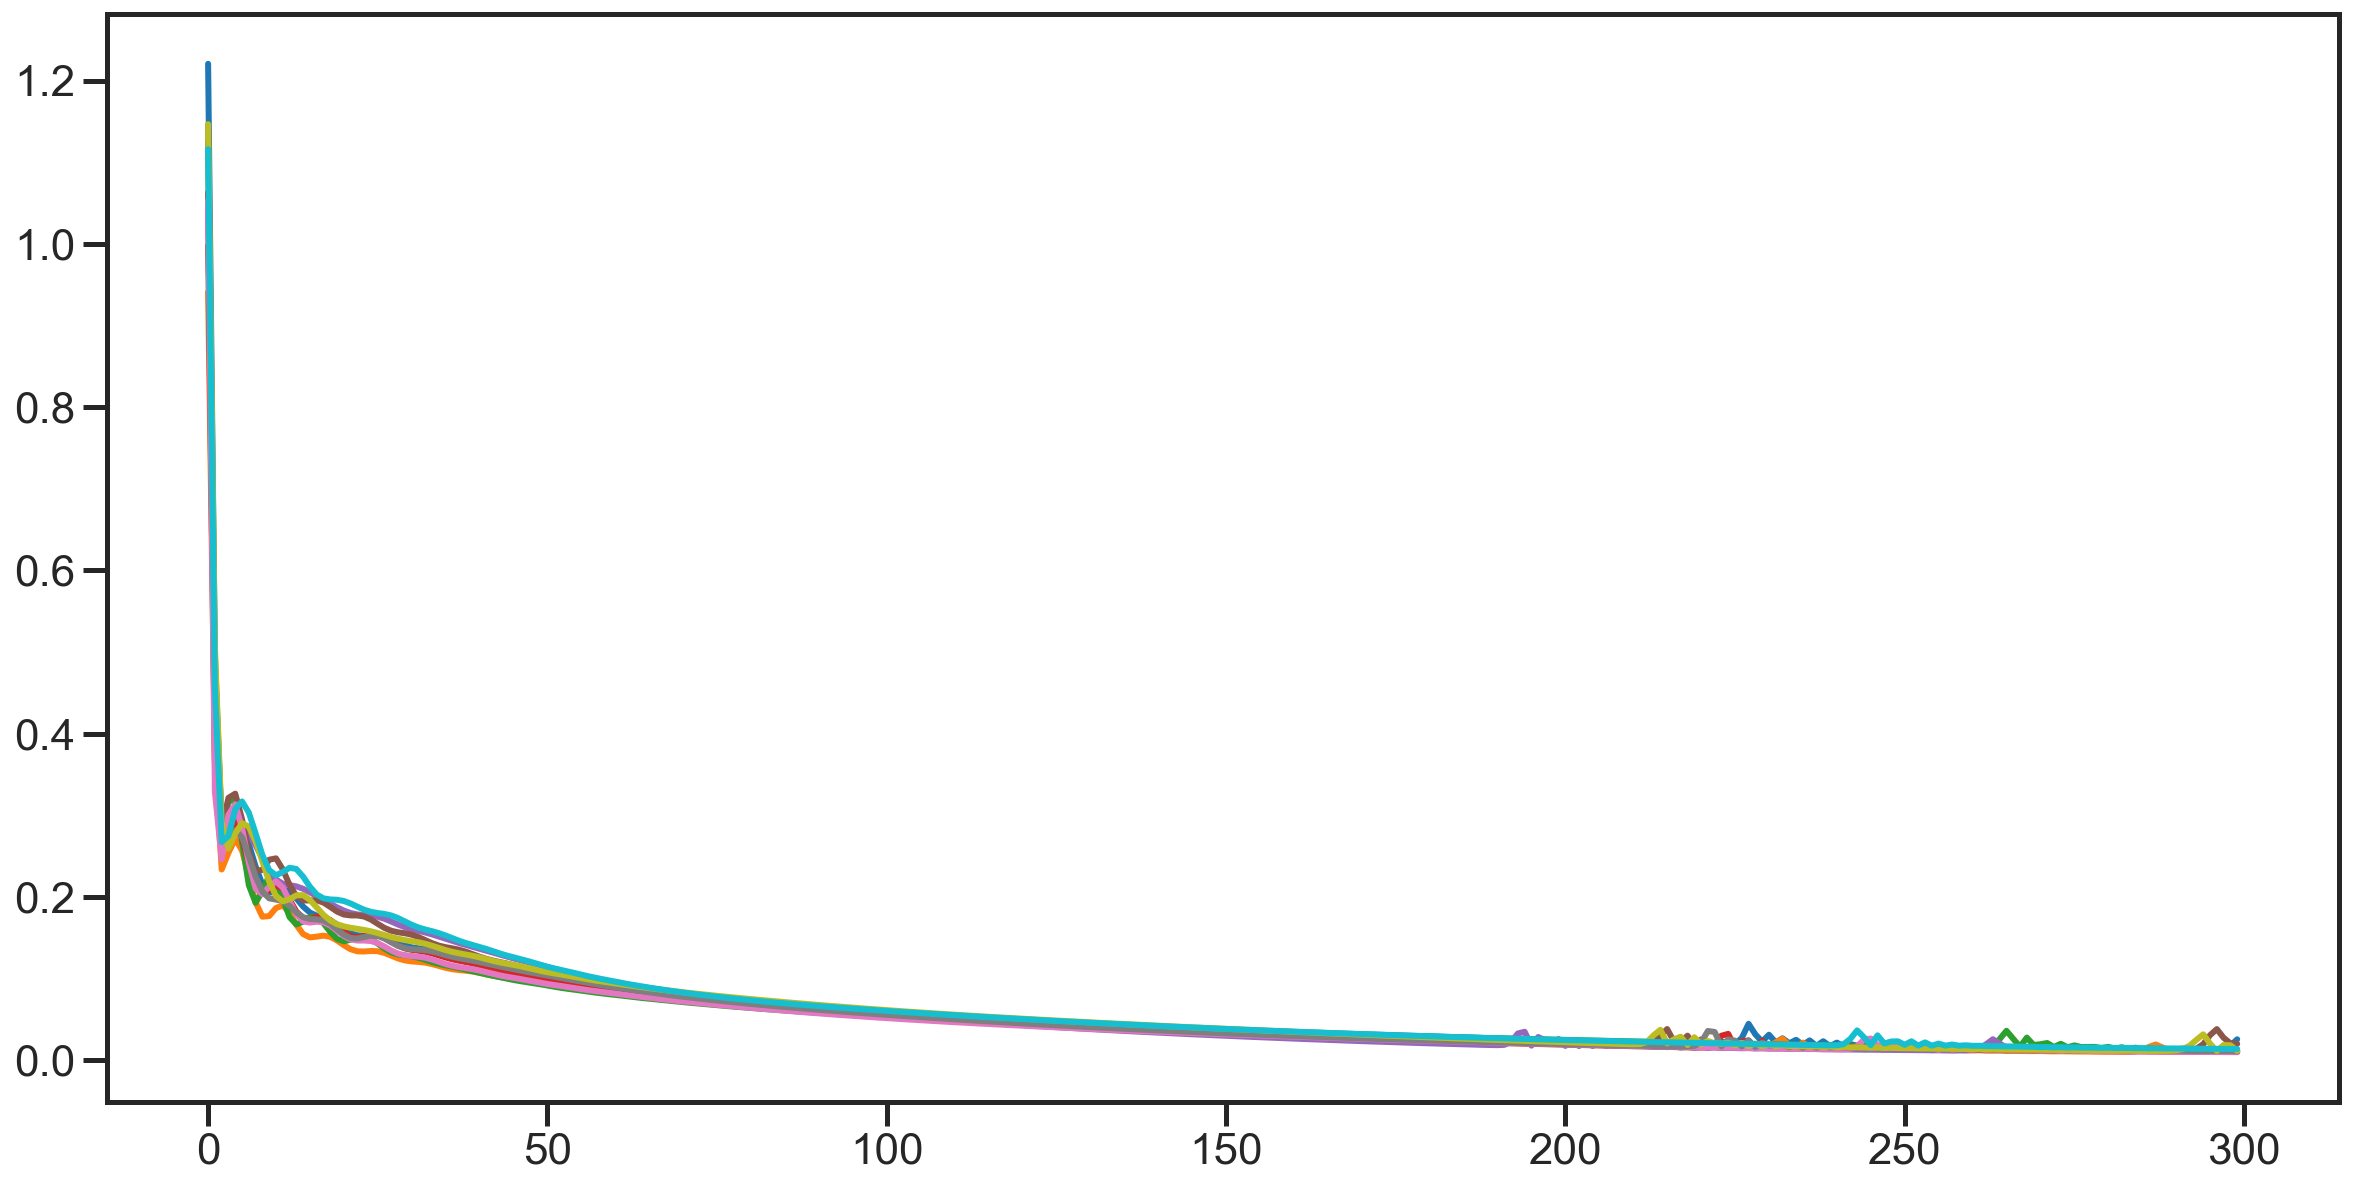

In [26]:
%%time

losses = []

for i in trange(epochs):
    losses.append(bootstrap.fit_model(X_train,y_train))
    
    
plt.plot(losses)
print(f'final loss: {losses[-1]}')

cobeau: (0.3165868201287494, 1.4732585063355118e-06)
nlpd: -1.6873512697510504.
 nlpds of just mean and just std of the model:
0.4136553852883003
nan
error: 0.22099116441525704


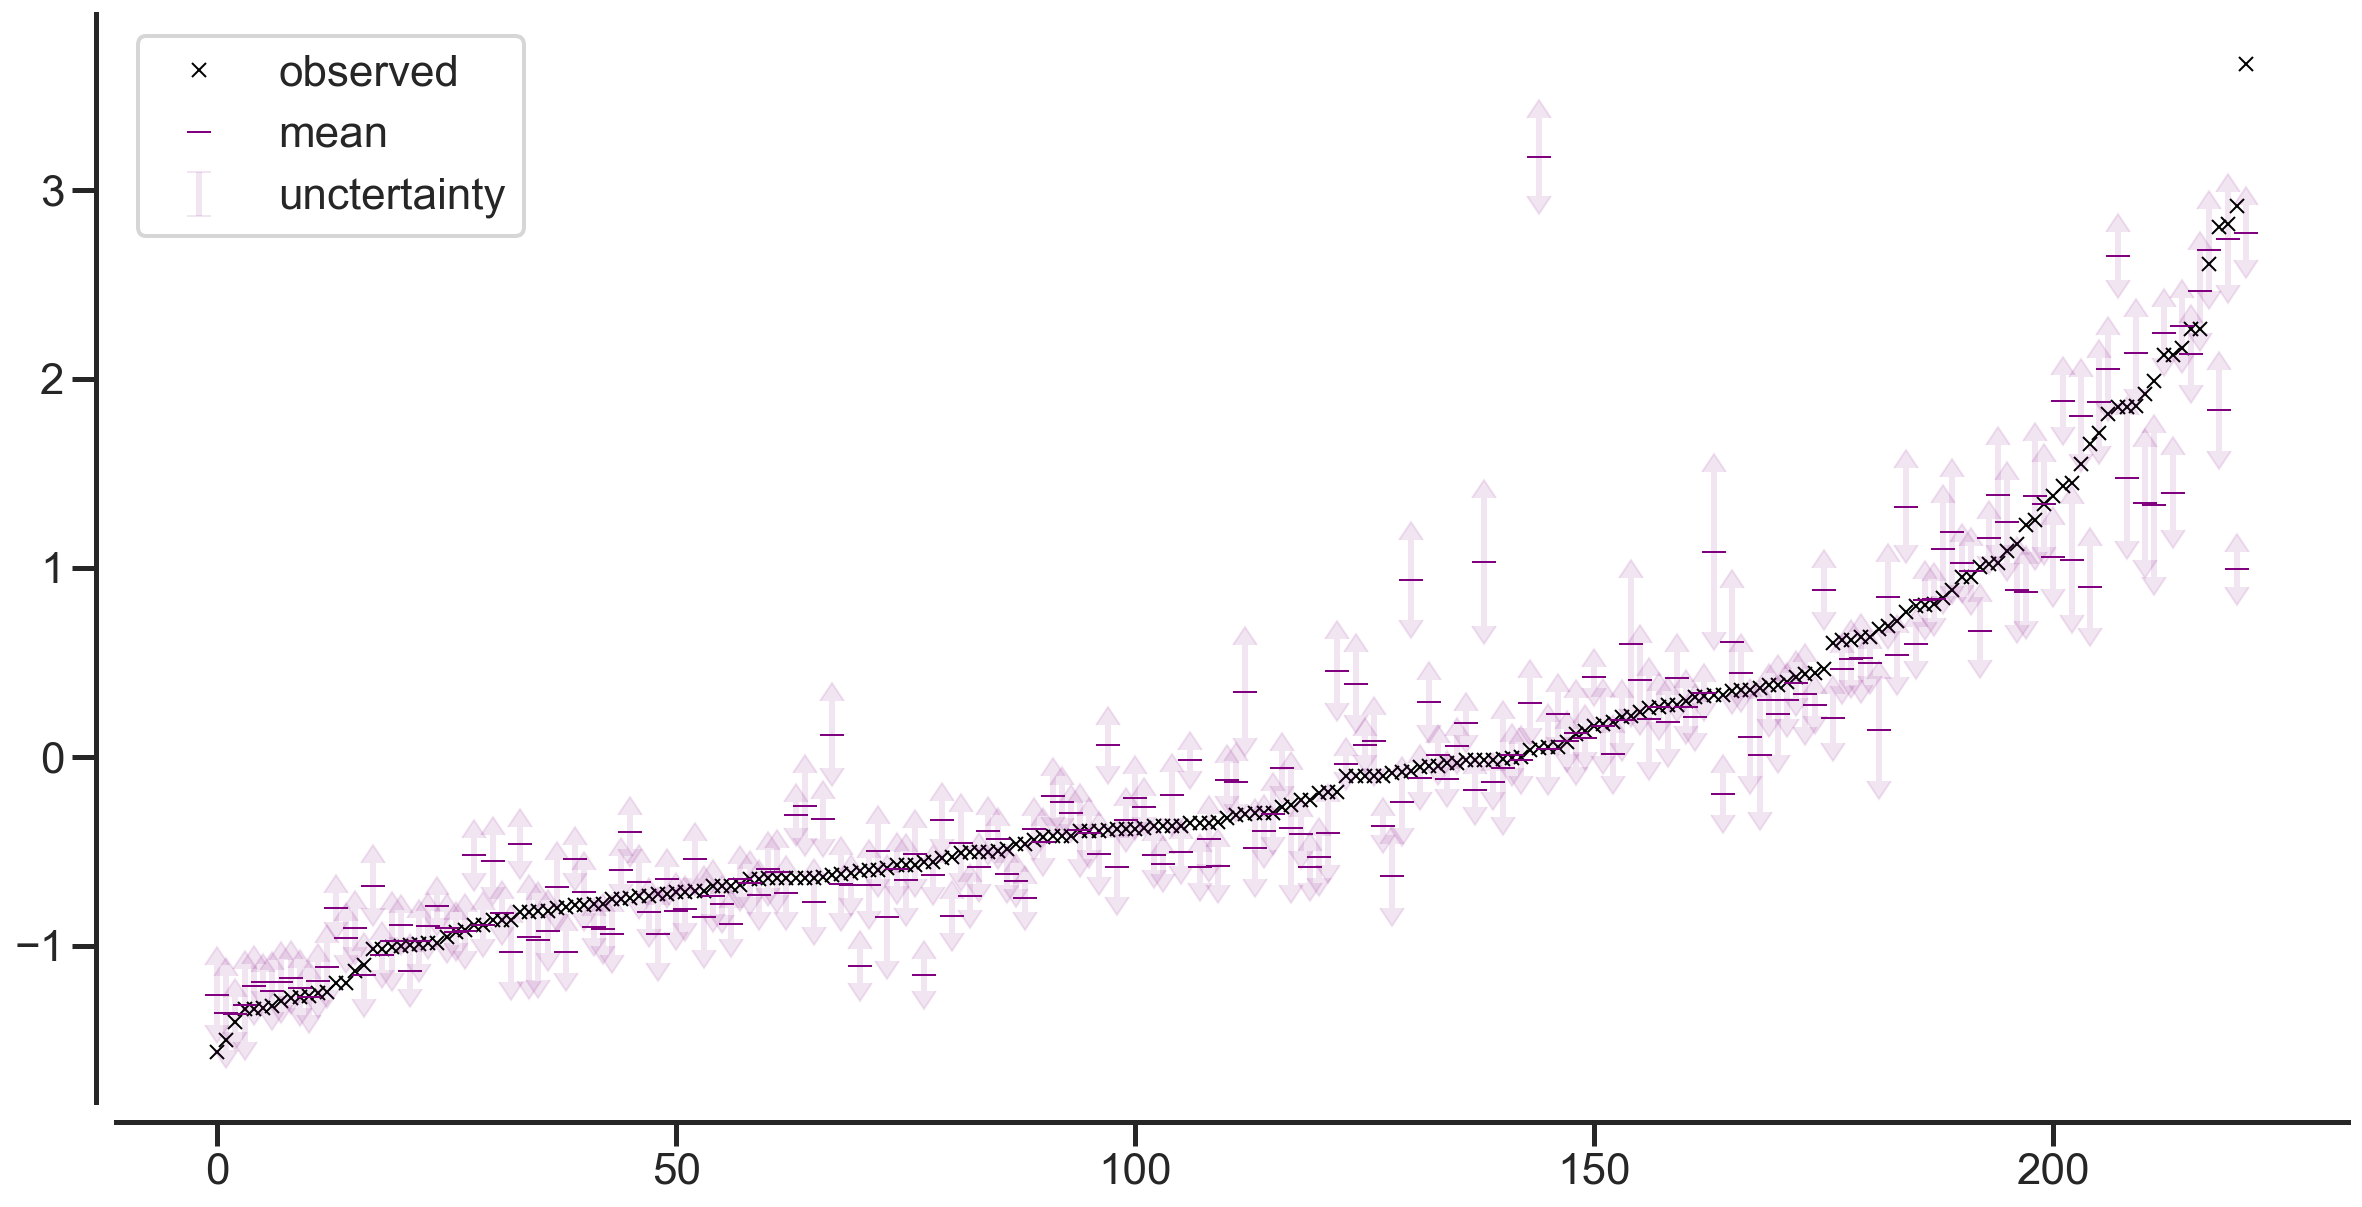

In [27]:
plot_uncertainty(bootstrap,X_test,y_test,toy,all_predictions=all_predictions)

In [28]:
from nn_models.models import SaverModel

showcase_code('nn_models/models.py','SaverModel')


In [29]:
saver = SaverModel(toy,output_dims)

100%|████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 51.33it/s]


final loss: 0.016888894140720367
Wall time: 5.87 s


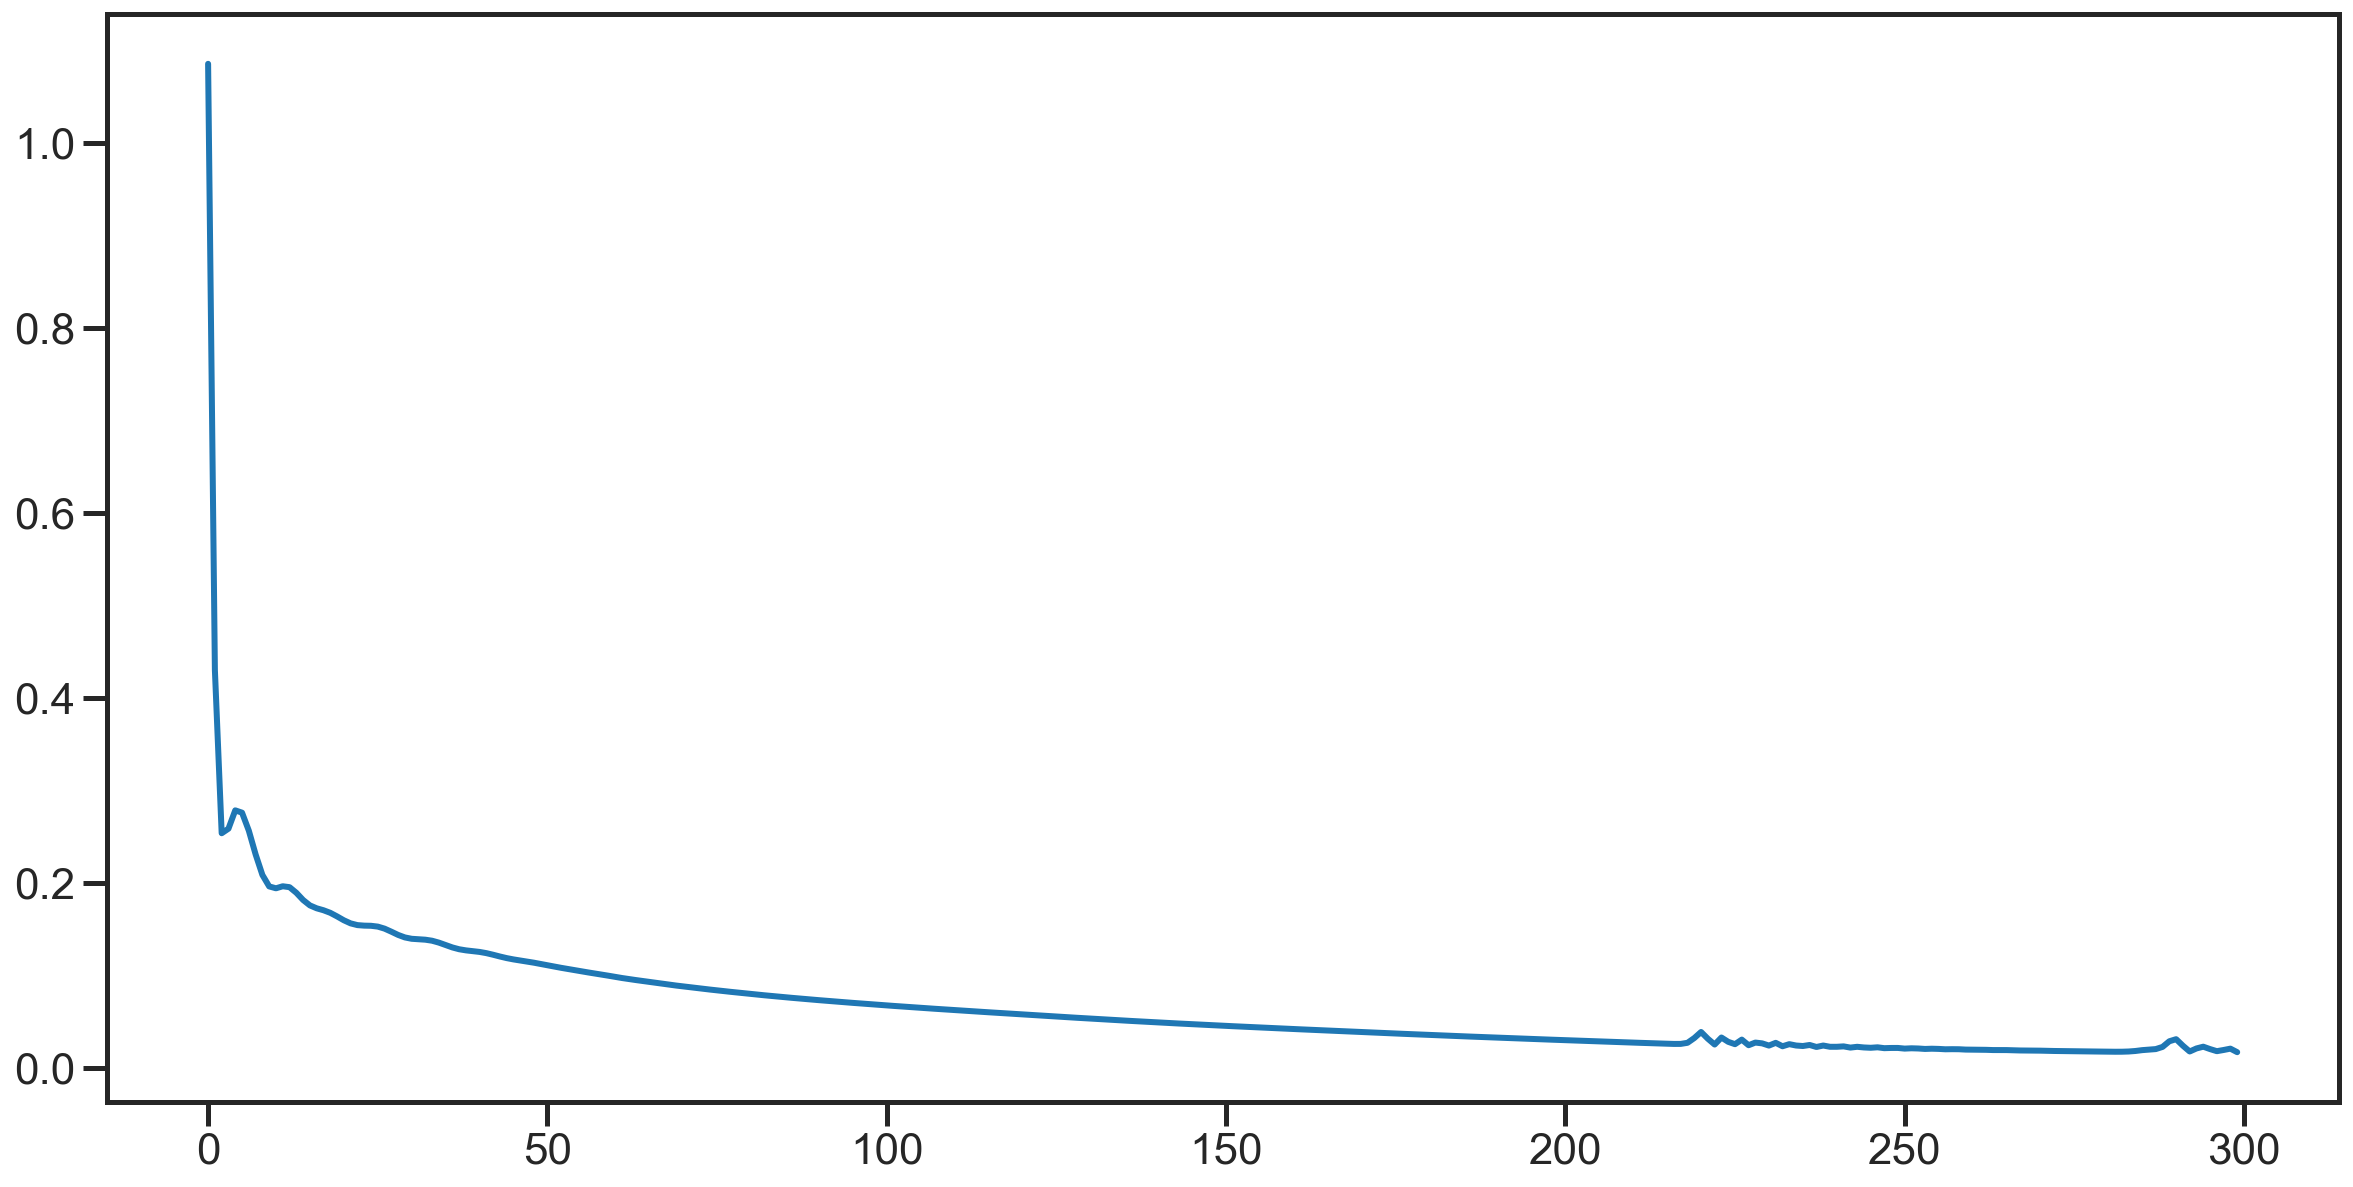

In [30]:
%%time

losses = []

for i in trange(epochs):
    losses.append( saver.fit_model(X_train,y_train))
    
    
plt.plot(losses)
print(f'final loss: {losses[-1]}')

cobeau: (0.18897656915059277, 0.004723725315697079)
nlpd: -1.3132898839616034.
 nlpds of just mean and just std of the model:
0.4136553852883003
nan
error: 0.20551308746983696


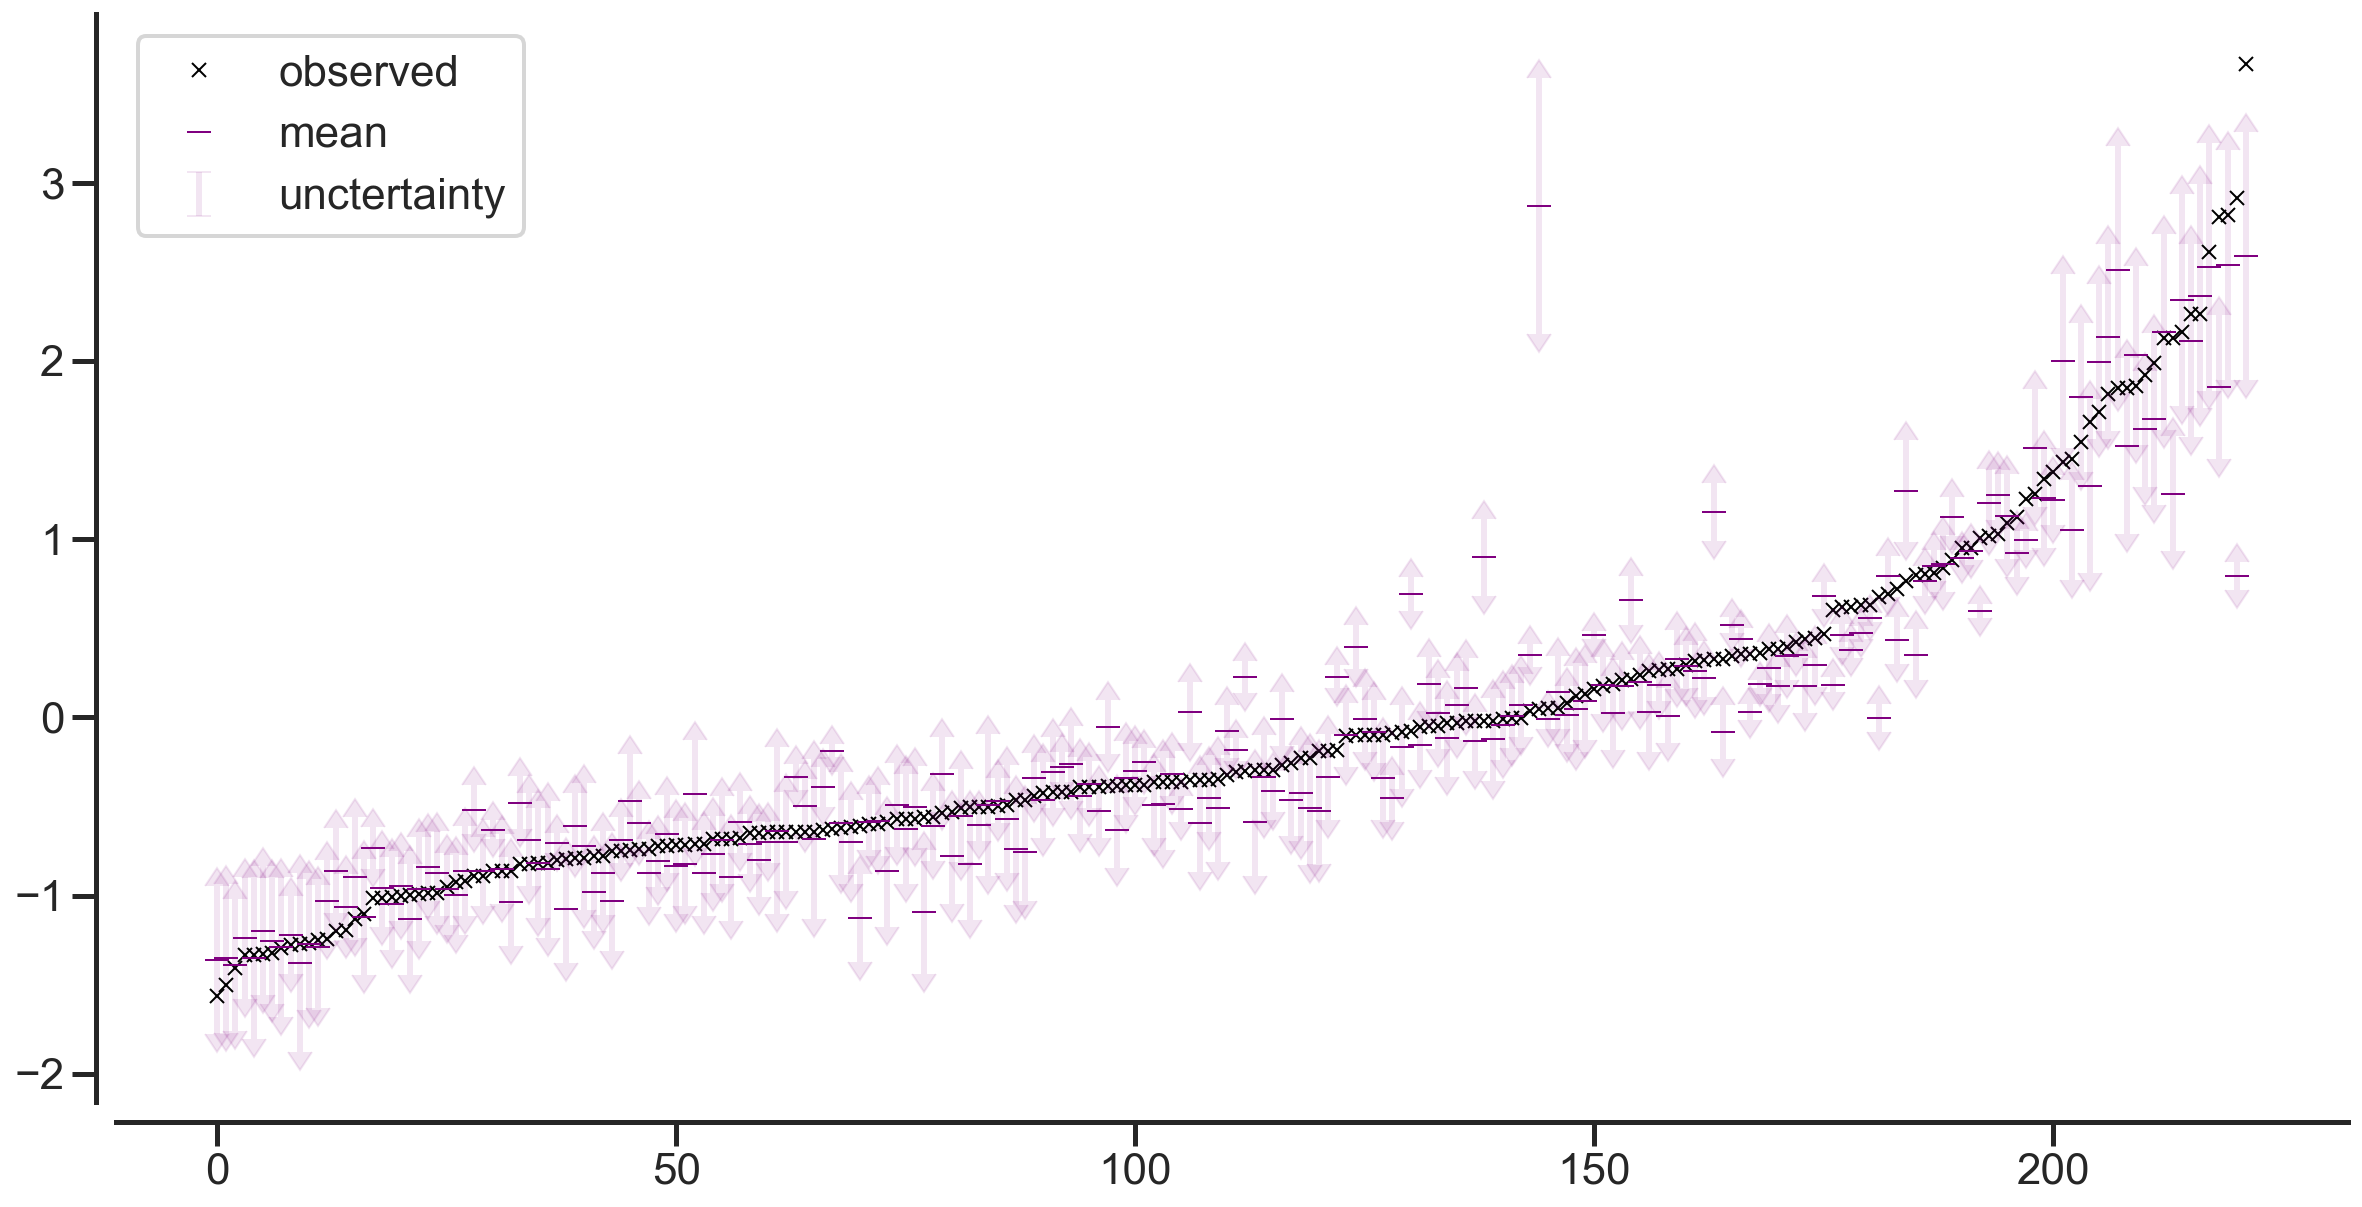

In [31]:
plot_uncertainty(saver,X_test,y_test,toy,all_predictions=all_predictions)

In [32]:
from nn_models.models import BobstrapEnsemble

showcase_code('nn_models/models.py','BobstrapEnsemble')


In [33]:
bob = BobstrapEnsemble(toy ,output_dims,num_epochs_per_save=100)

In [34]:
bob.num_epochs_per_save

100

100%|████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 70.08it/s]


final loss: 0.017061904072761536
Wall time: 4.3 s


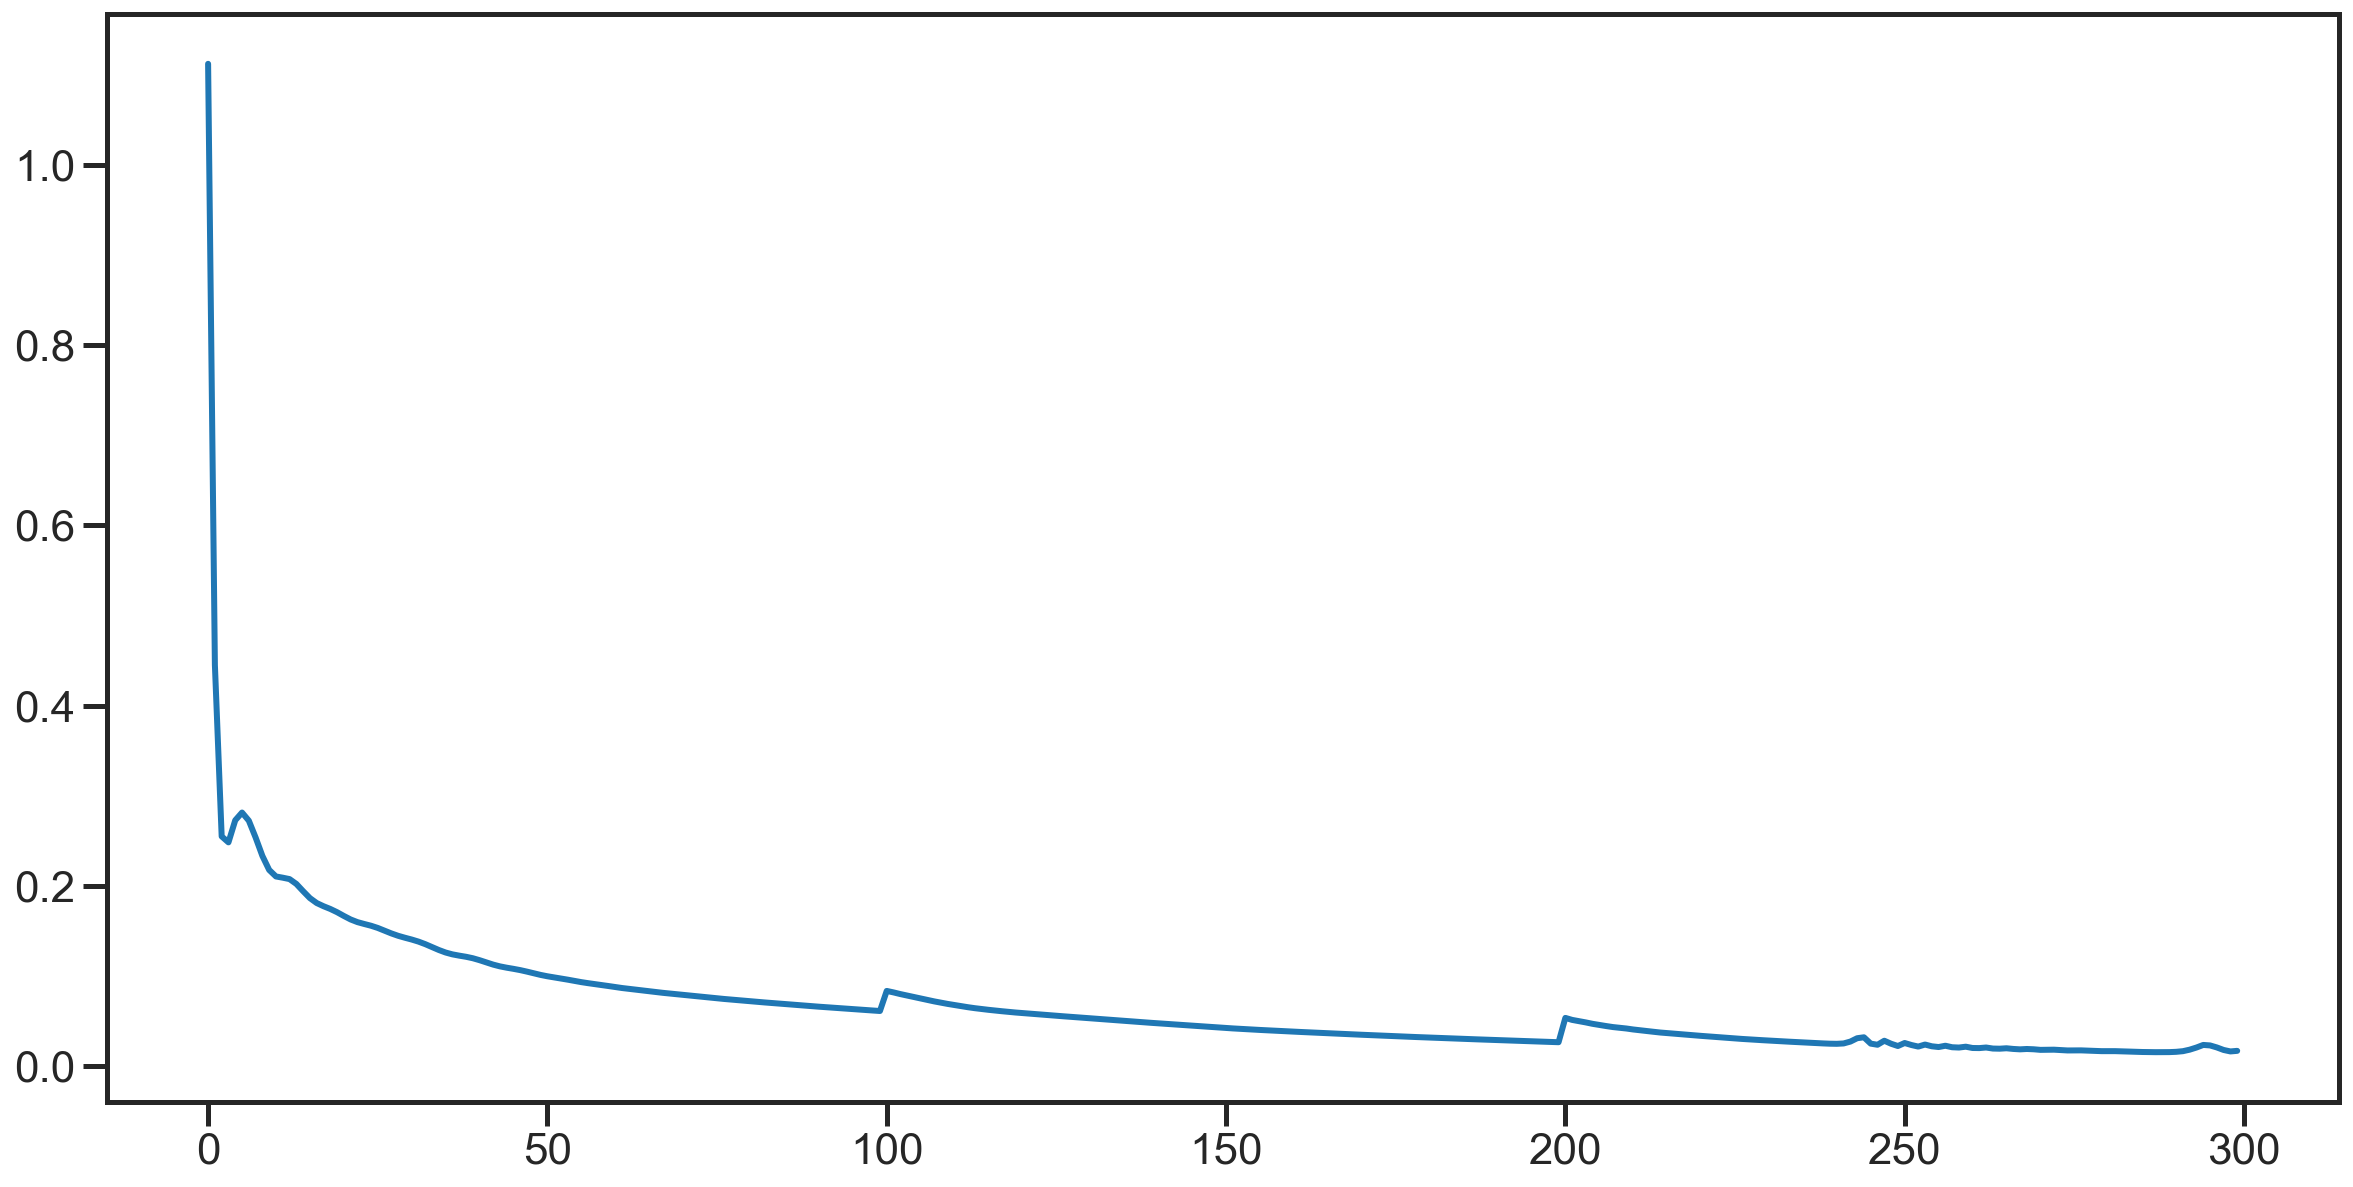

In [35]:
%%time

losses = []

for i in trange(epochs):
    losses.append( bob.fit_model(X_train,y_train))
    
    
plt.plot(losses)
print(f'final loss: {losses[-1]}')

cobeau: (0.32220847194933416, 9.335977663300866e-07)
nlpd: -1.5711228604036258.
 nlpds of just mean and just std of the model:
0.4136553852883003
nan
error: 0.20164026247924635


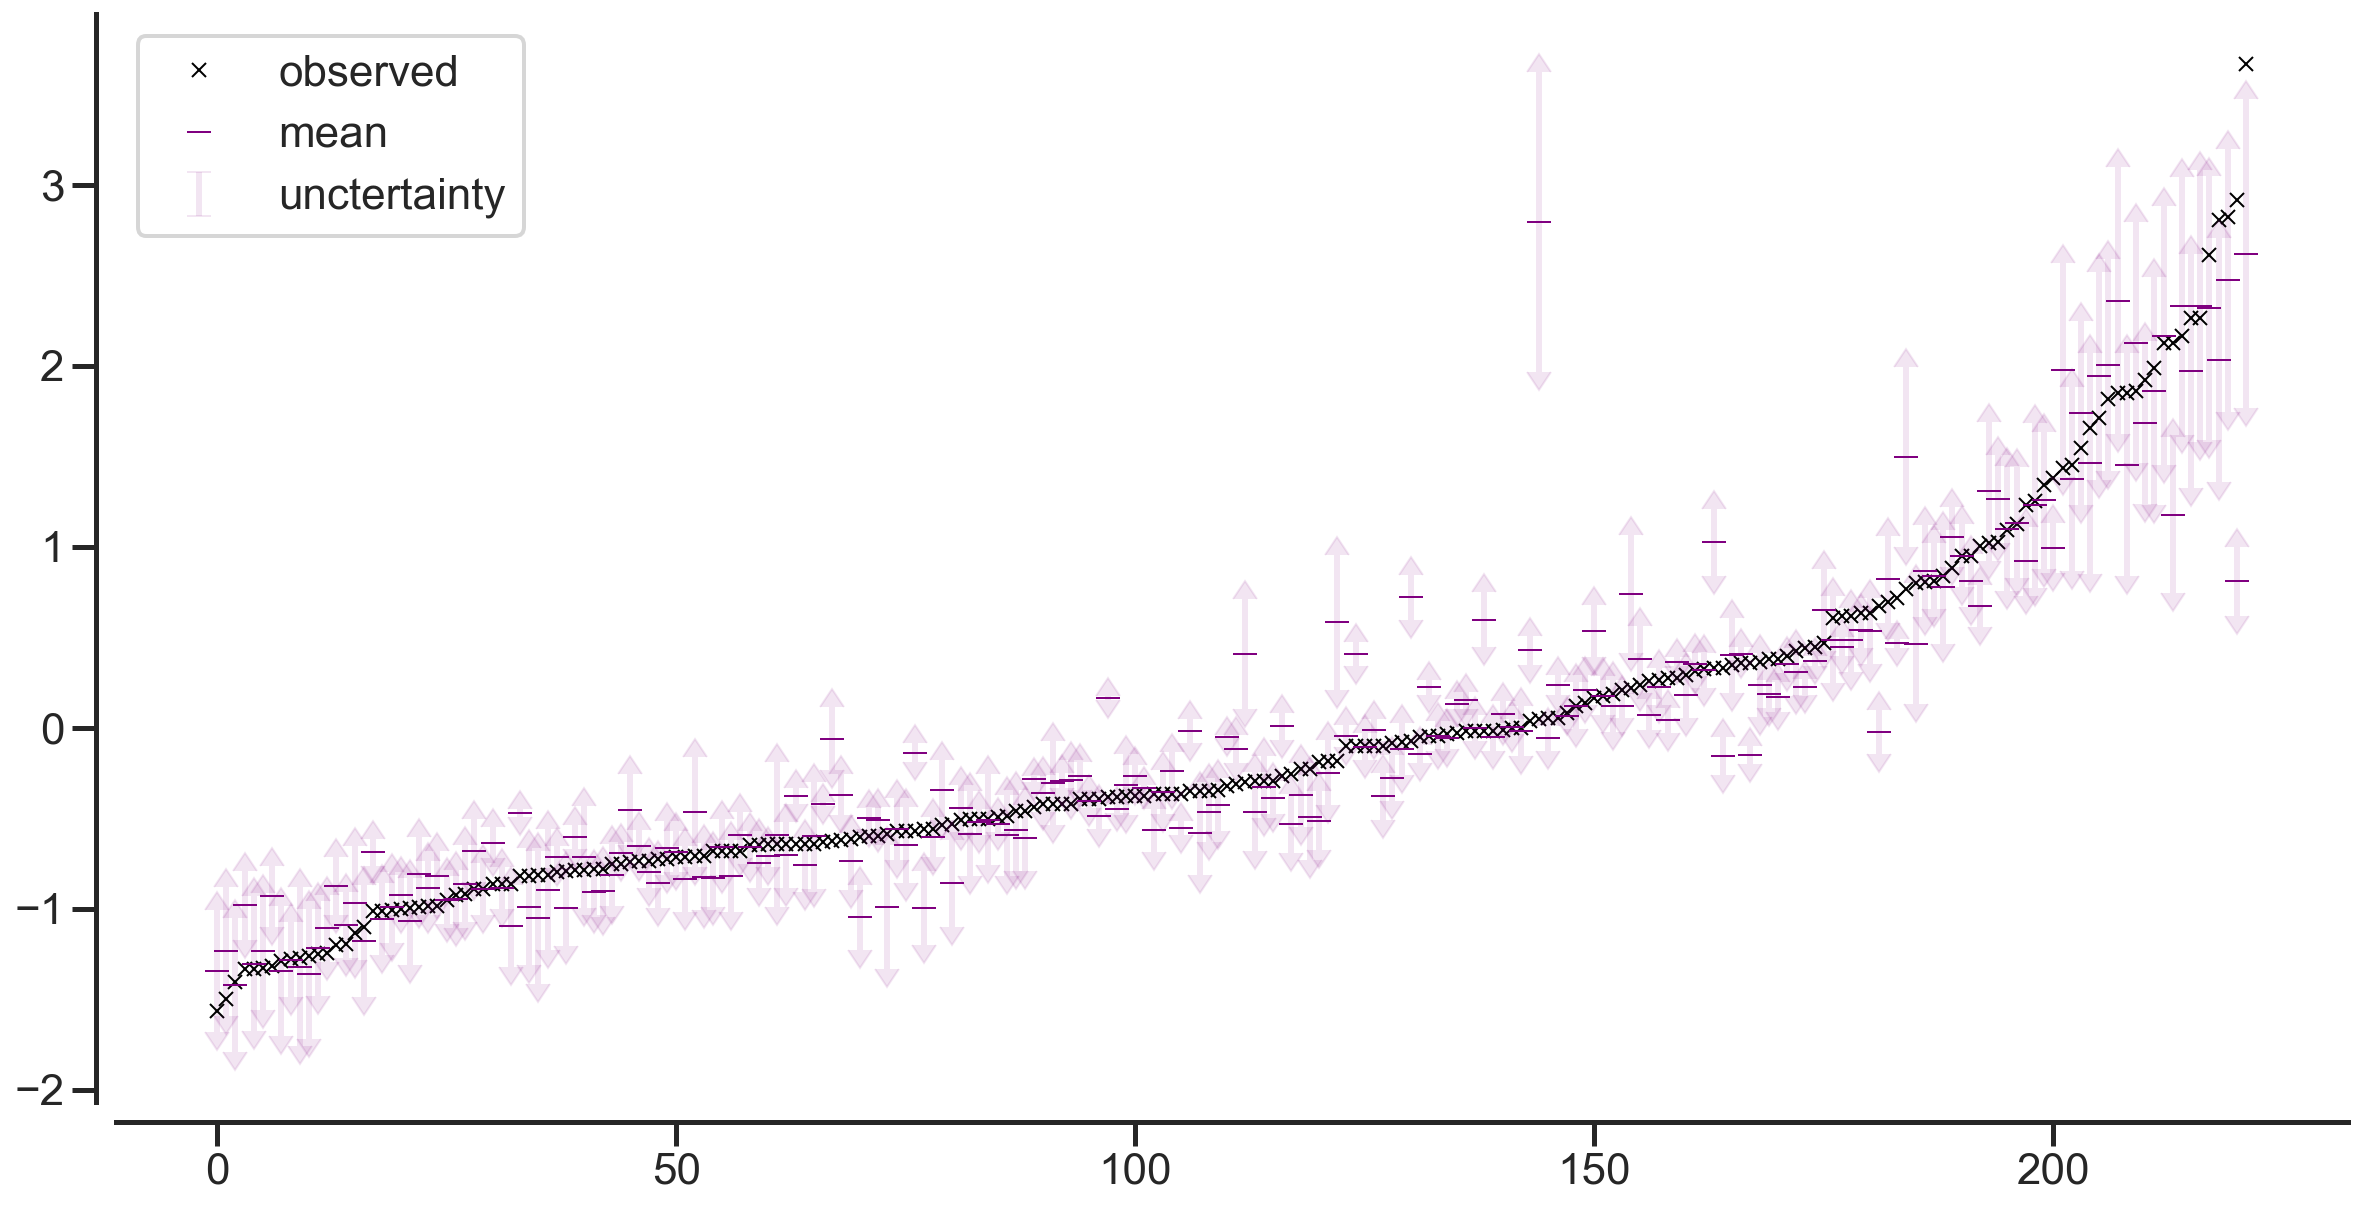

In [36]:
plot_uncertainty(bob,X_test,y_test,toy,all_predictions=all_predictions)

In [37]:
from nn_models.models import DropoutModel

showcase_code('nn_models/models.py','DropoutModel')



In [38]:
dropout = DropoutModel(toy,output_dims,p=0.05)

100%|████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:13<00:00, 46.10it/s]


final loss: 0.0776263177394867
Wall time: 13 s


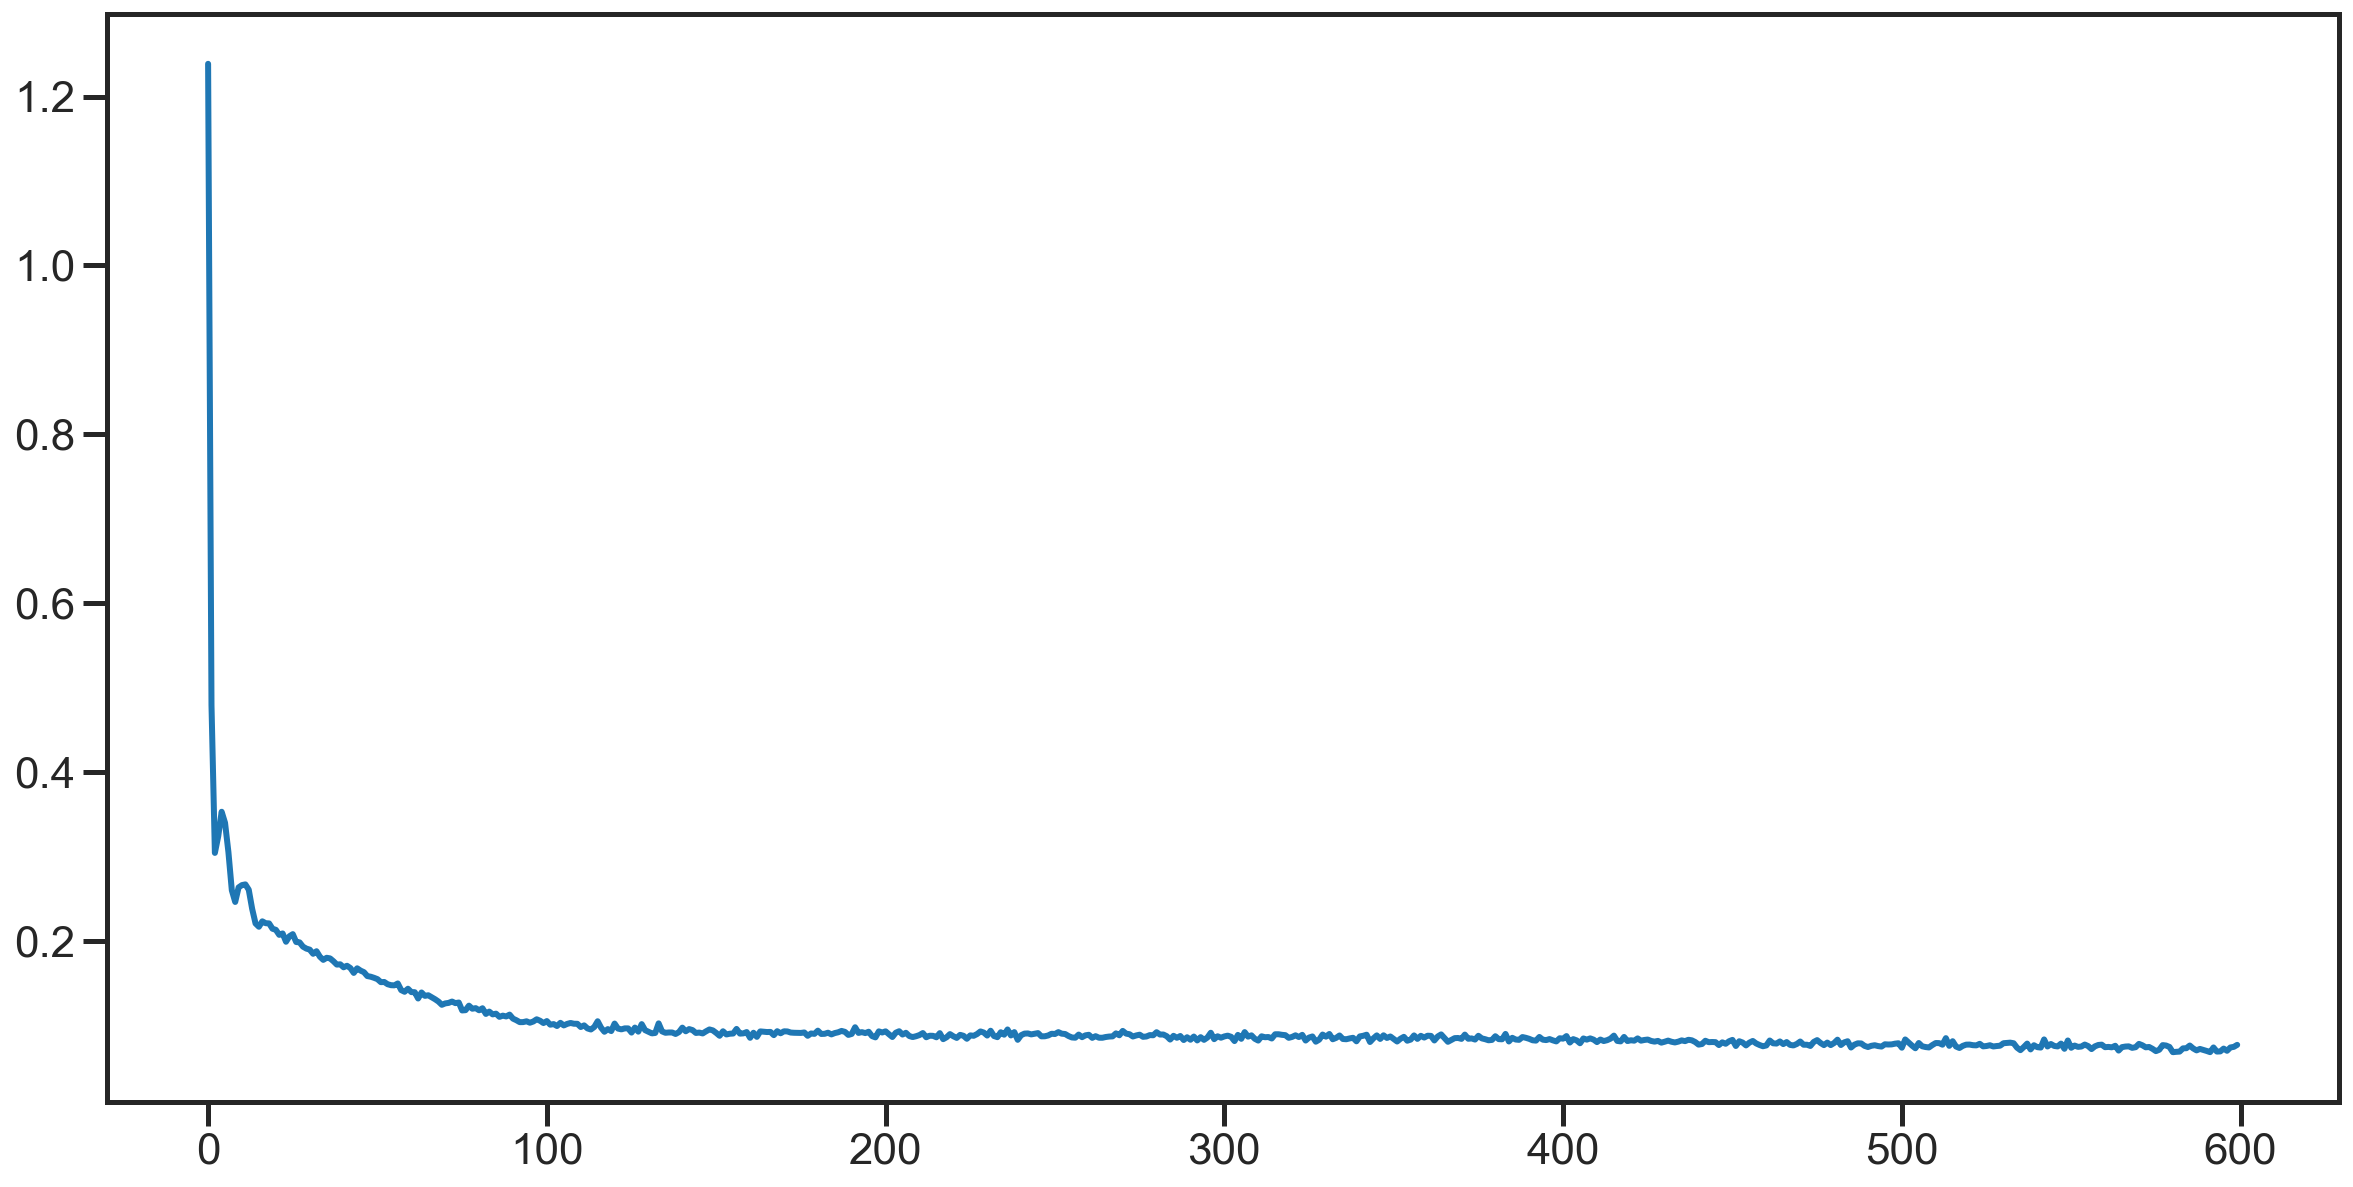

In [39]:
%%time

losses = []

for i in trange(epochs*2):
    losses.append( dropout.fit_model(X_train,y_train))
    
    
plt.plot(losses)
print(f'final loss: {losses[-1]}')

100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 854.90it/s]


cobeau: (0.09549236261929386, 0.15618651939809636)
nlpd: -1.6452189258868881.
 nlpds of just mean and just std of the model:
0.4136553852883003
nan
error: 0.22103468503273446


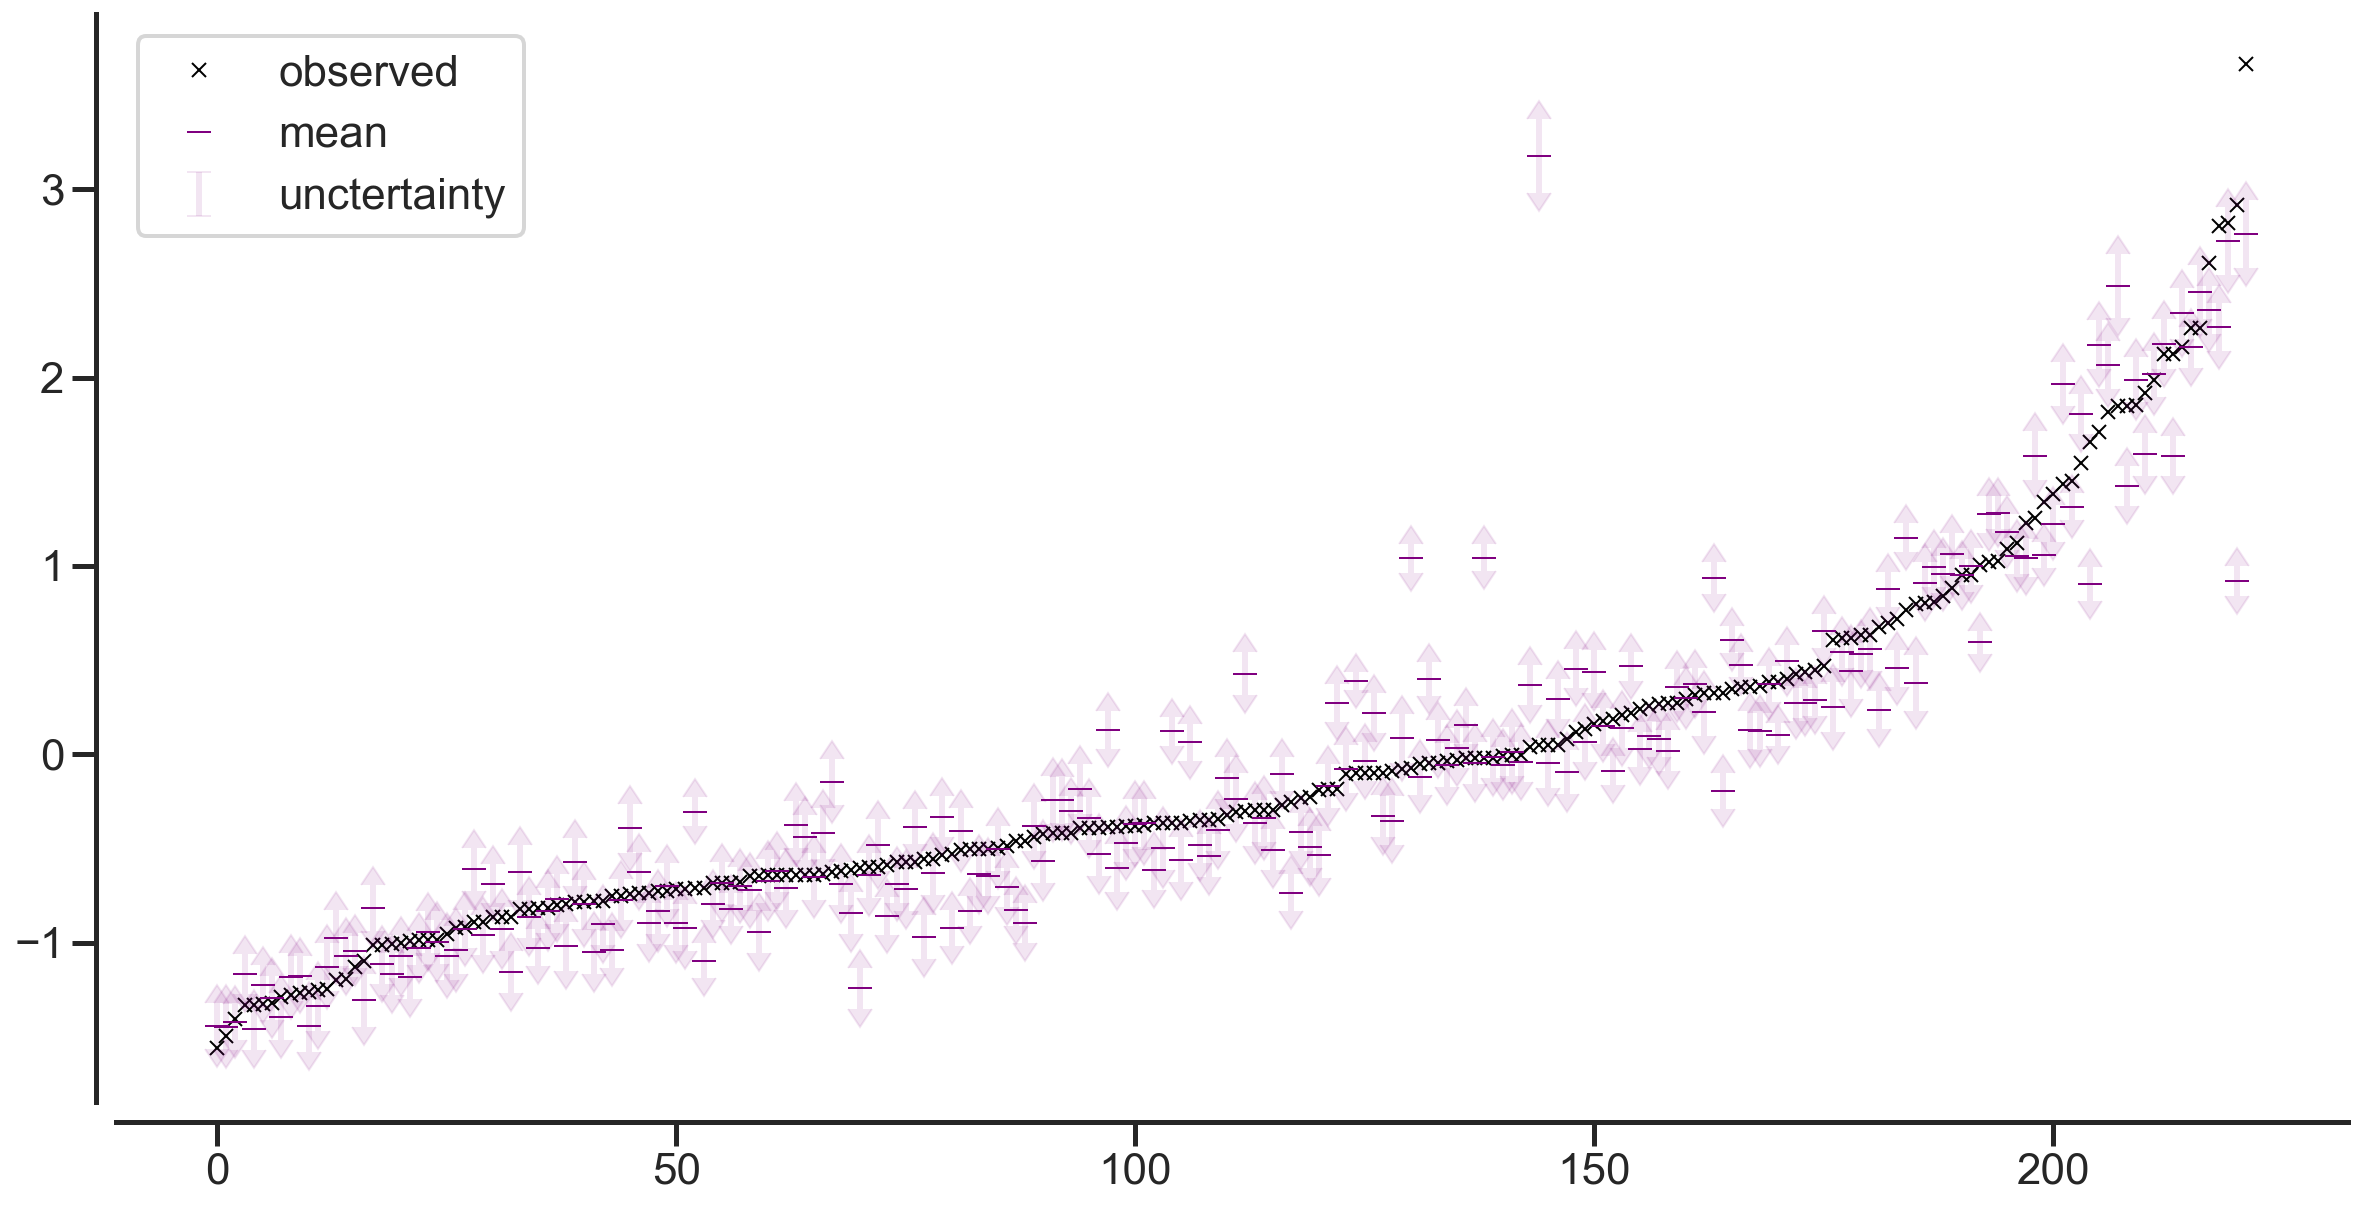

In [40]:
plot_uncertainty(dropout,X_test,y_test,toy,all_predictions=all_predictions)